In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 
sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
import warnings
warnings.filterwarnings("ignore")




# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor



from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


from tqdm import tqdm


# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations
pd.set_option("display.max_columns", None)


In [2]:
df_min=pd.read_csv("../../datos/datos2/datos_nulos_minmax.csv", index_col=0).reset_index(drop=True)


In [3]:
df_min["rooms"]=df_min["rooms"].astype("O")
df_min["bathrooms"]=df_min["bathrooms"].astype("O")

In [4]:
df_min.head(2)

price propertyType  exterior rooms bathrooms                municipality  \
0  750.0         flat      True     1         1                      Madrid   
1  750.0         flat      True     2         1  San Sebastián de los Reyes   

  status floor hasLift  size_MinMax  distance_MinMax  
0   good     3    True     0.425532         0.121497  
1   good    bj   False     0.531915         0.282949

Primero identificamos los outliers en univariados

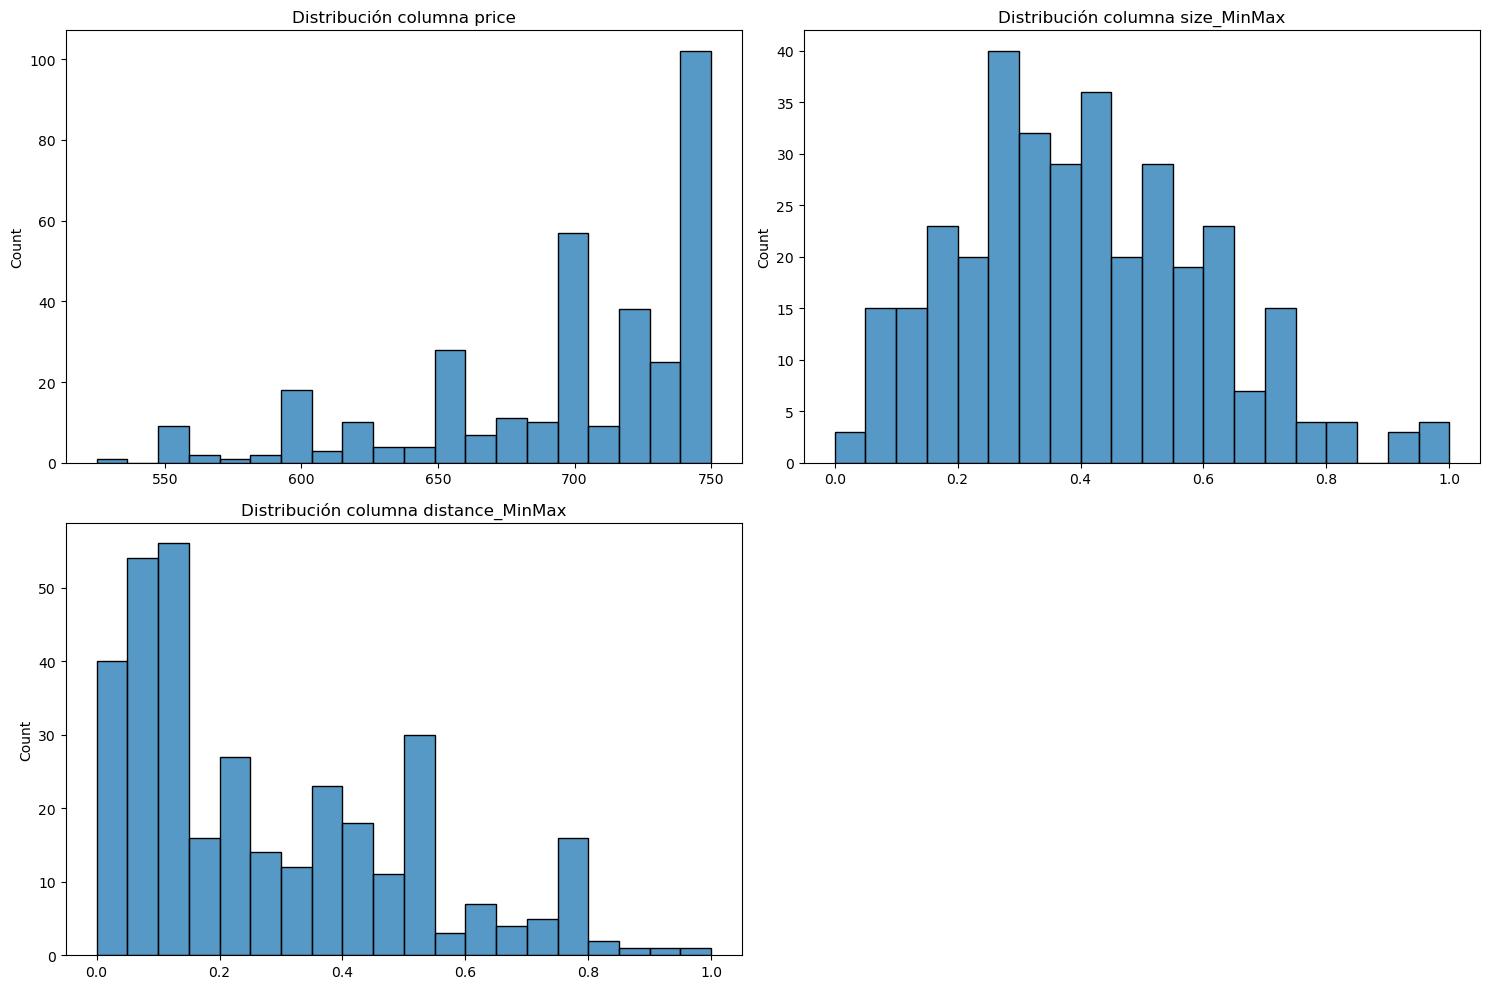

In [5]:
f.plot_outliers_univariados(df_min, "h", (15,10))

Recuerdo la distribución de las numéricas ya seleccionadas mediante la metodología de escalador min max

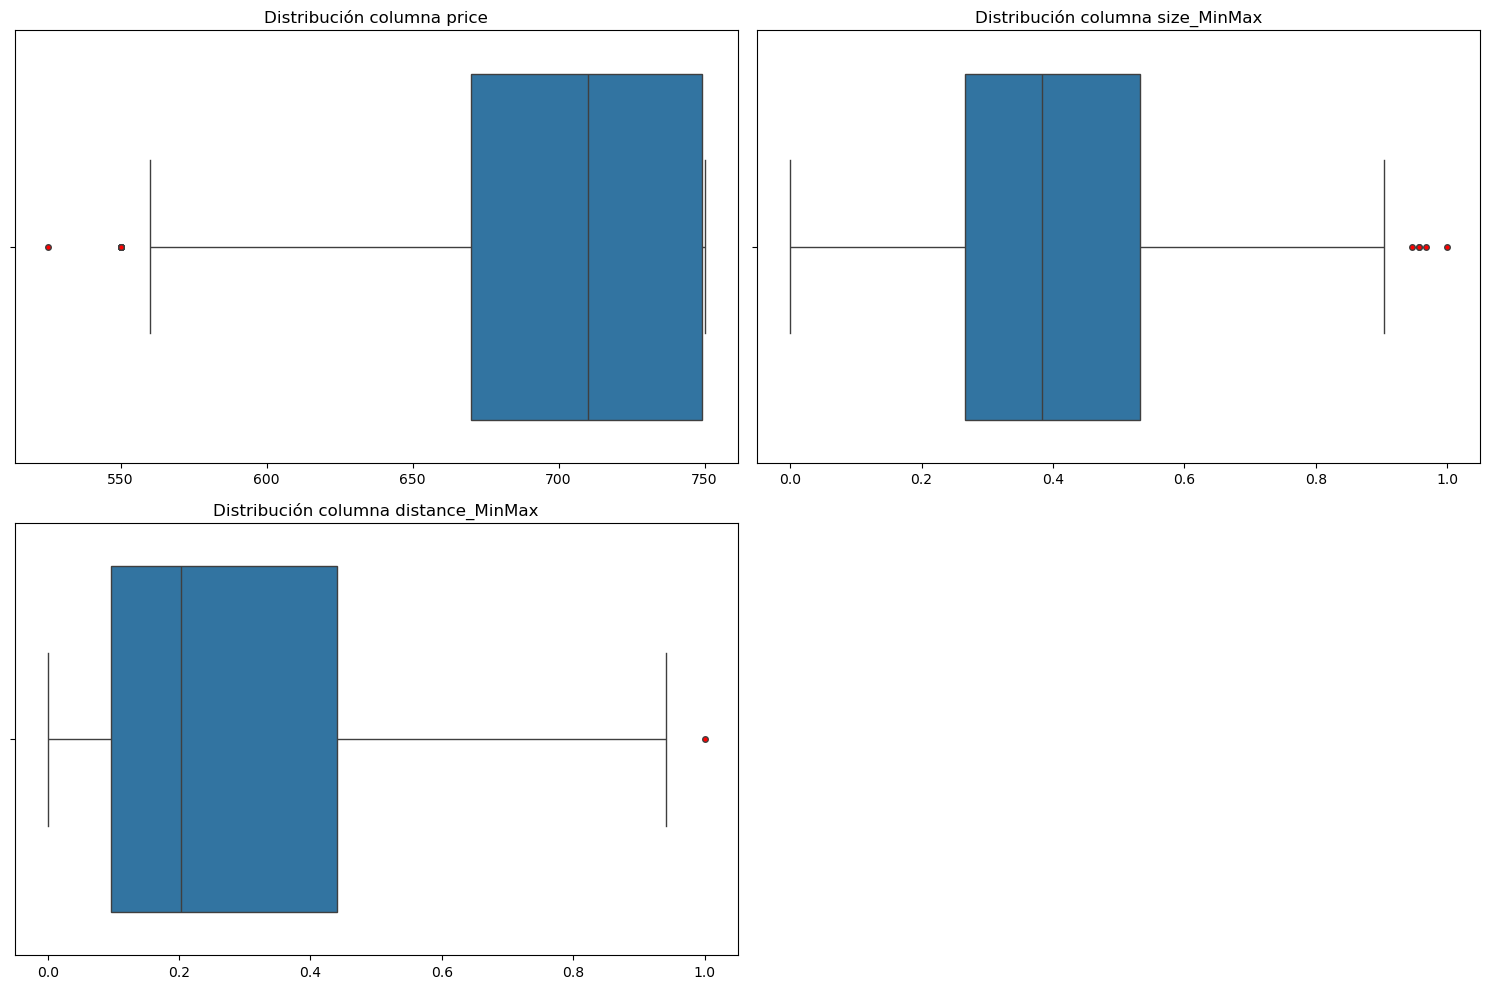

In [6]:
f.plot_outliers_univariados(df_min, "b", (15,10))

Observo los outliers de las numéricas ya seleccionadas mediante la metodología de escalador min max

In [7]:
num=df_min.select_dtypes(include=np.number)
num.describe().T

count        mean        std    min         25%         50%  \
price            341.0  697.390029  53.570490  525.0  670.000000  710.000000   
size_MinMax      341.0    0.403756   0.203151    0.0    0.265957    0.382979   
distance_MinMax  341.0    0.279412   0.228378    0.0    0.095669    0.203552   

                        75%    max  
price            749.000000  750.0  
size_MinMax        0.531915    1.0  
distance_MinMax    0.440147    1.0

In [8]:
dicc_zsc=f.identificar_outliers_zscore(df_min)

La cantidad de outliers para la PRICE es de 1 outliers
La cantidad de outliers para la SIZE_MINMAX es de 0 outliers
La cantidad de outliers para la DISTANCE_MINMAX es de 1 outliers


Dado que no tienen una distribución normal ninguna de ellas, no utilizaré el Z-Score ya que el porcentaje de fallo será demasiado alto. Por ello opto por el IQR

In [9]:
dicc_iqr=f.identificar_outliers_iqr(df_min)

La columna PRICE tiene 10 outliers
La columna SIZE_MINMAX tiene 5 outliers
La columna DISTANCE_MINMAX tiene 1 outliers


Nos fijamos en que parece haber muy pocos Outliers

In [10]:
dicc_iqr["price"].head(2)

price propertyType  exterior rooms bathrooms municipality status floor  \
6   550.0         flat      True     1         1       Madrid   good     1   
10  550.0         flat      True     2         1      Arganda   good    en   

   hasLift  size_MinMax  distance_MinMax  
6    False     0.351064         0.067804  
10   False     0.361702         0.461773

In [11]:
dicc_iqr["size_MinMax"].head(2)

price propertyType  exterior rooms bathrooms municipality status  \
170  750.0         flat      True     2         2        Parla   good   
217  720.0         flat     False     2         1        Parla   good   

           floor hasLift  size_MinMax  distance_MinMax  
170            6    True     0.968085         0.361619  
217  desconocido    True     0.957447         0.376403

Observamos como el número de outliers es muy bajo por lo general y parecen estar muy separados entre ellos. Esto me lleva a pensar que un IFO podría ser la mejor opción. Sin embargo, vamos a comprobarlo. 

In [12]:
contaminacion= [0.01, 0.05, 0.1]
estimadores = [100,400,1000, 2000] 
combinaciones= list(product(contaminacion, estimadores))
for cont, esti in combinaciones:
    
    ifo=IsolationForest(random_state=42, n_estimators=esti, contamination= cont, n_jobs=-1)         #n_estimator es el número de árboles y n_jobs con -1 coge todos los nucleos del ordenador

    df_min[f"outliers_ifo_{cont}_{esti}"]=ifo.fit_predict(df_min[["price","size_MinMax","distance_MinMax"]]) 

In [13]:
df_min["outliers_ifo_0.01_100"].value_counts(normalize=True)    #Esto nos muetsra como se acerca mucho al 1% de outliers por el nivel de contaminación ser 0.01

outliers_ifo_0.01_100
 1    0.98827
-1    0.01173
Name: proportion, dtype: float64

In [14]:
df_min.head()

price propertyType  exterior rooms bathrooms                municipality  \
0  750.0         flat      True     1         1                      Madrid   
1  750.0         flat      True     2         1  San Sebastián de los Reyes   
2  590.0         flat      True     3         2                   Rascafría   
3  684.0       studio      True     0         1                      Madrid   
4  600.0         flat      True     2         1          Manzanares el Real   

        status        floor      hasLift  size_MinMax  distance_MinMax  \
0         good            3         True     0.425532         0.121497   
1         good           bj        False     0.531915         0.282949   
2         good  desconocido        False     0.531915         1.000000   
3  desconocido  desconocido  desconocido     0.265957         0.185649   
4         good            3        False     0.563830         0.653732   

   outliers_ifo_0.01_100  outliers_ifo_0.01_400  outliers_ifo_0.01_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.01_2000  outliers_ifo_0.05_100  outliers_ifo_0.05_400  \
0                       1                      1                      1   
1                       1                      1                      1   
2                      -1                     -1                     -1   
3                       1                      1                      1   
4                       1                      1                      1   

   outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  outliers_ifo_0.1_100  \
0                       1                       1                     1   
1                       1                       1                     1   
2                      -1                      -1                    -1   
3                       1                       1                     1   
4                       1                       1                     1   

   outliers_ifo_0.1_400  outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
0                     1                      1                      1  
1                     1                      1                      1  
2                    -1                     -1                     -1  
3                     1                      1                      1  
4                     1                      1                      1

In [15]:
columnas_hue=df_min.filter(like="outliers")

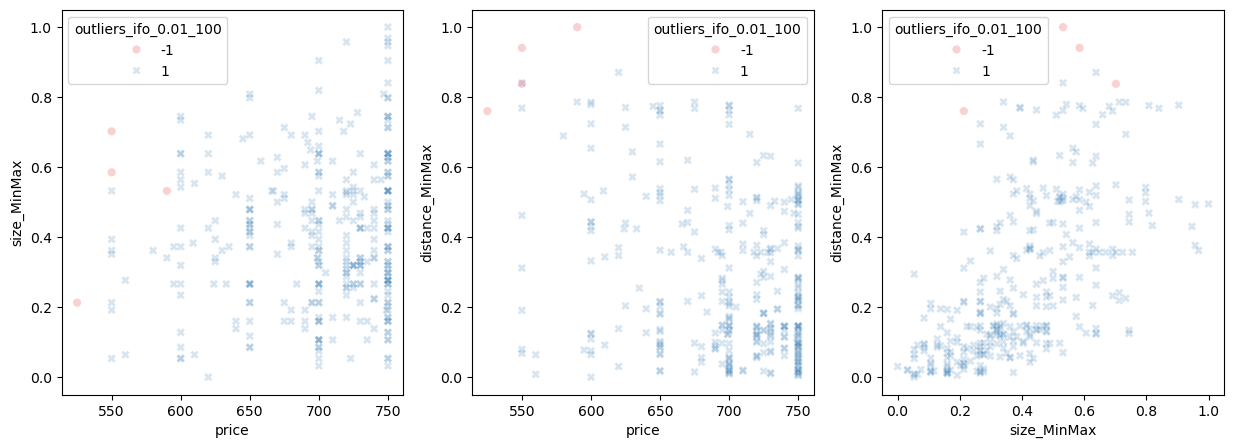

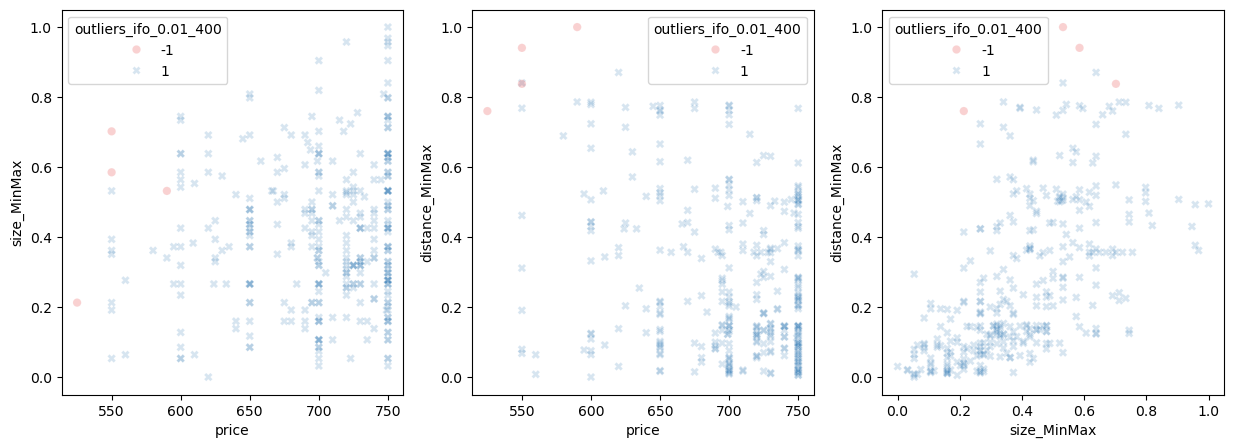

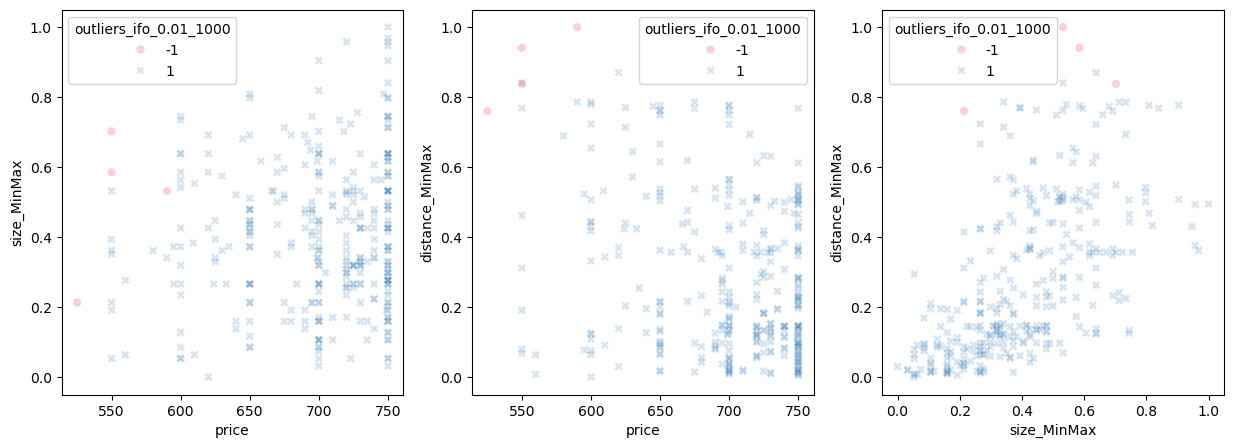

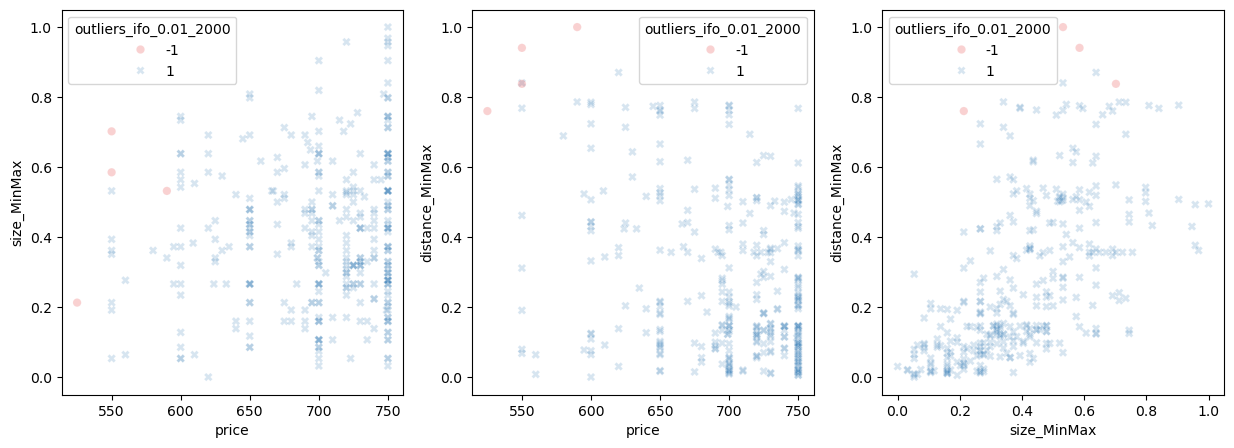

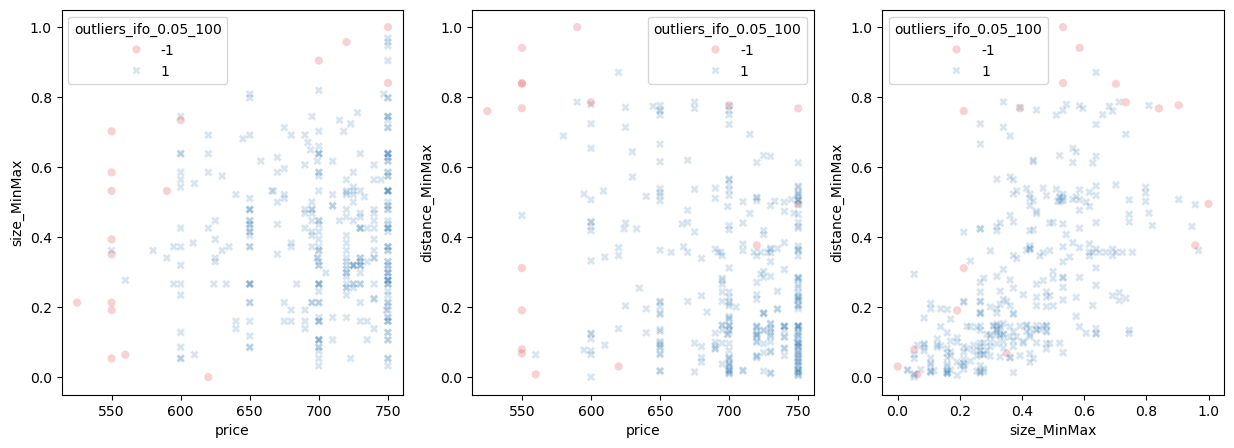

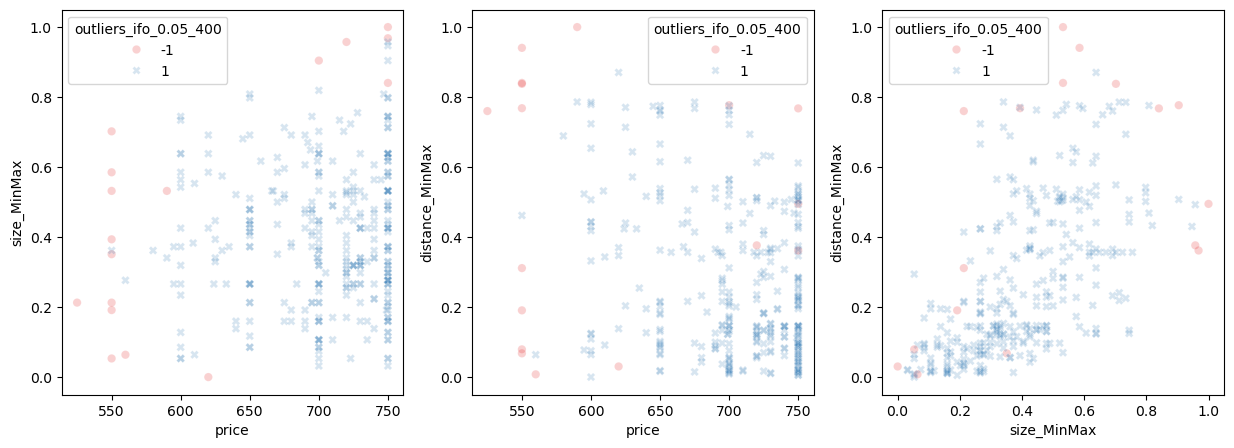

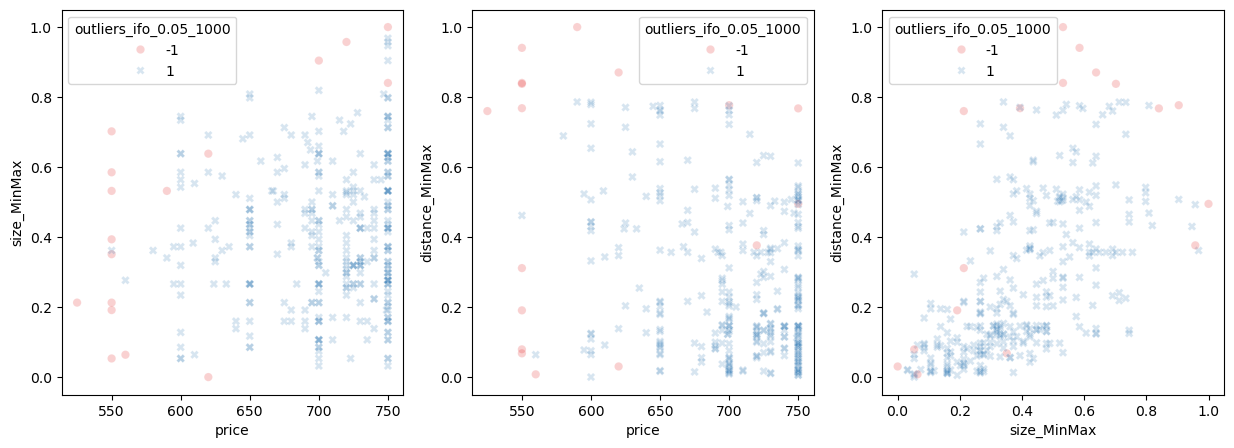

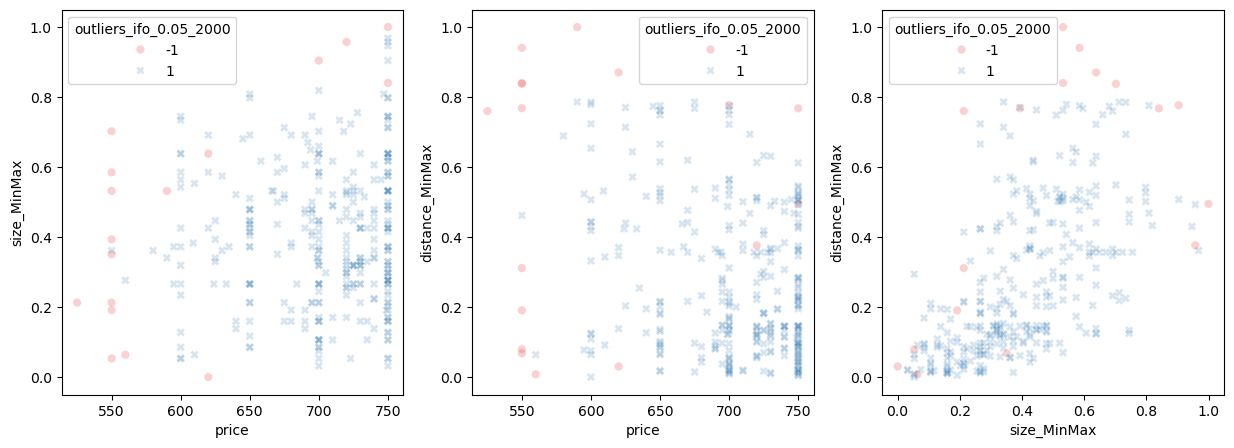

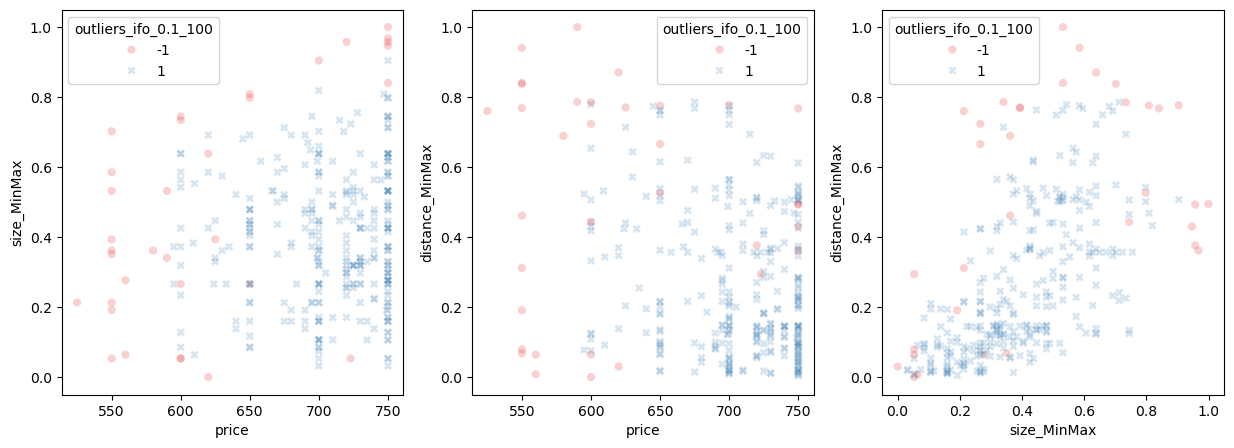

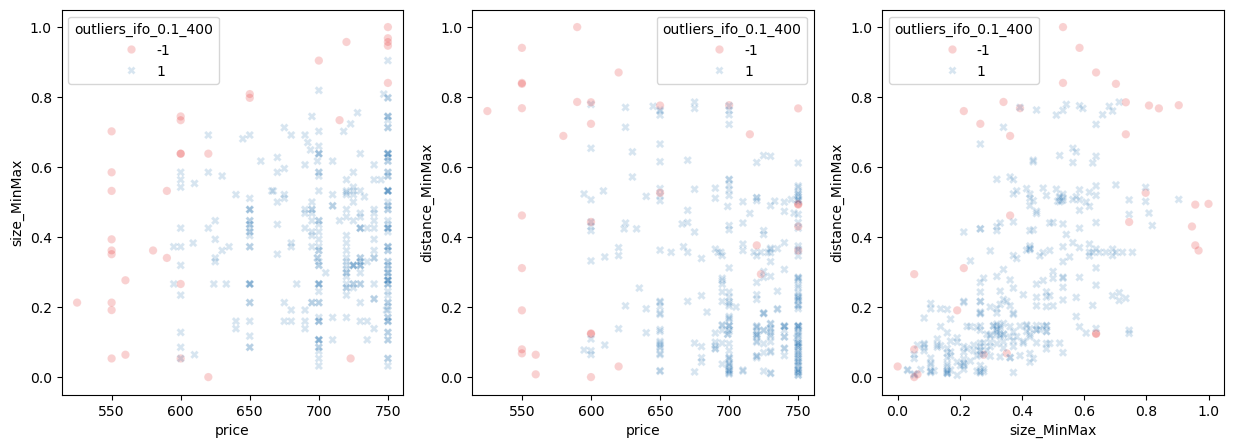

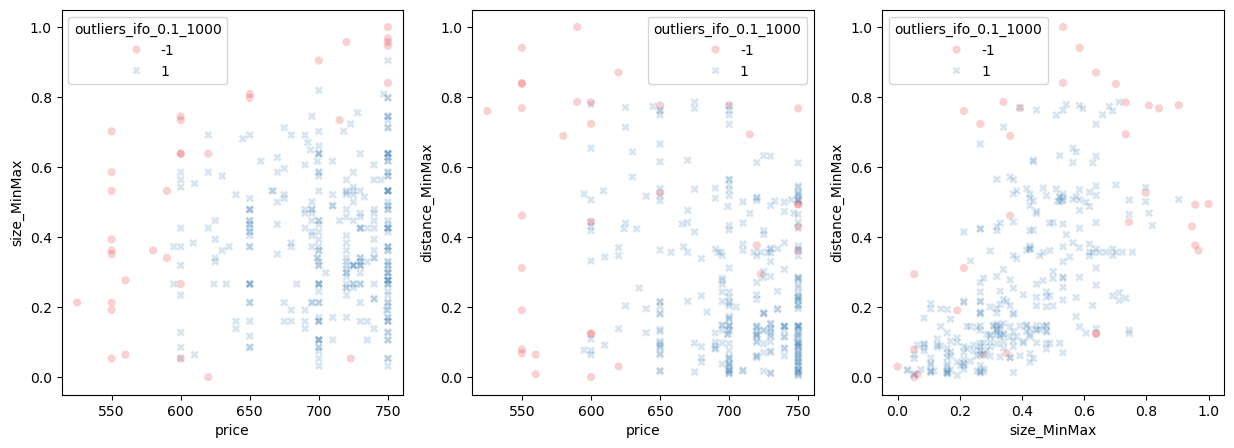

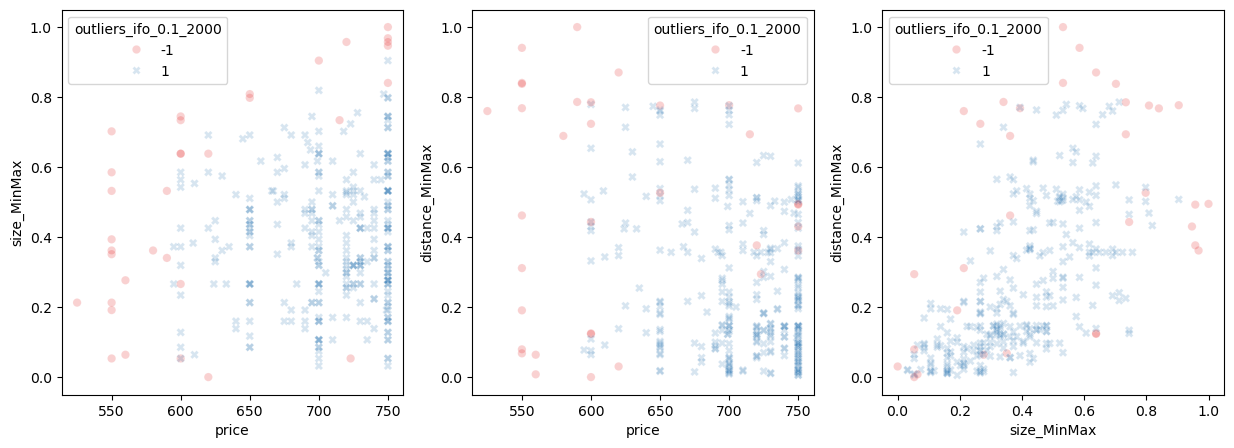

In [16]:
combinaciones_visual=list(combinations(["price","size_MinMax","distance_MinMax"], 2))

for out in columnas_hue:


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,5))
    axes=axes.flat
    for indice, tupla in enumerate(combinaciones_visual):
        sns.scatterplot(x=tupla[0], y=tupla[1], ax= axes[indice], data=df_min, hue= out, palette= "Set1", alpha= 0.2, style= out)

Observamos como a mayor número de arboles los outliers se van agrupando más.  
Además según vamos siendo más estrictos con el nivel de contaminación, más sentido tiene la interpretación. 
Podemos observar como el IFO nos muestrá que por lo general los precios bajos son considerados outliers.

In [17]:
df_min.head()

price propertyType  exterior rooms bathrooms                municipality  \
0  750.0         flat      True     1         1                      Madrid   
1  750.0         flat      True     2         1  San Sebastián de los Reyes   
2  590.0         flat      True     3         2                   Rascafría   
3  684.0       studio      True     0         1                      Madrid   
4  600.0         flat      True     2         1          Manzanares el Real   

        status        floor      hasLift  size_MinMax  distance_MinMax  \
0         good            3         True     0.425532         0.121497   
1         good           bj        False     0.531915         0.282949   
2         good  desconocido        False     0.531915         1.000000   
3  desconocido  desconocido  desconocido     0.265957         0.185649   
4         good            3        False     0.563830         0.653732   

   outliers_ifo_0.01_100  outliers_ifo_0.01_400  outliers_ifo_0.01_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.01_2000  outliers_ifo_0.05_100  outliers_ifo_0.05_400  \
0                       1                      1                      1   
1                       1                      1                      1   
2                      -1                     -1                     -1   
3                       1                      1                      1   
4                       1                      1                      1   

   outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  outliers_ifo_0.1_100  \
0                       1                       1                     1   
1                       1                       1                     1   
2                      -1                      -1                    -1   
3                       1                       1                     1   
4                       1                       1                     1   

   outliers_ifo_0.1_400  outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
0                     1                      1                      1  
1                     1                      1                      1  
2                    -1                     -1                     -1  
3                     1                      1                      1  
4                     1                      1                      1


A pesar de que teóricamente el IFO por las carcaterísticas de los datos parece ser la mejor opción y tras haber observado que marca outliers en los precios ma´s bajo. Pasamos ahora a identificar los outliers con la metodología LOF.

Para poder comparar más fácil voy a sacar IFO y LOF juntos.

100%|██████████| 21/21 [00:02<00:00,  7.54it/s]


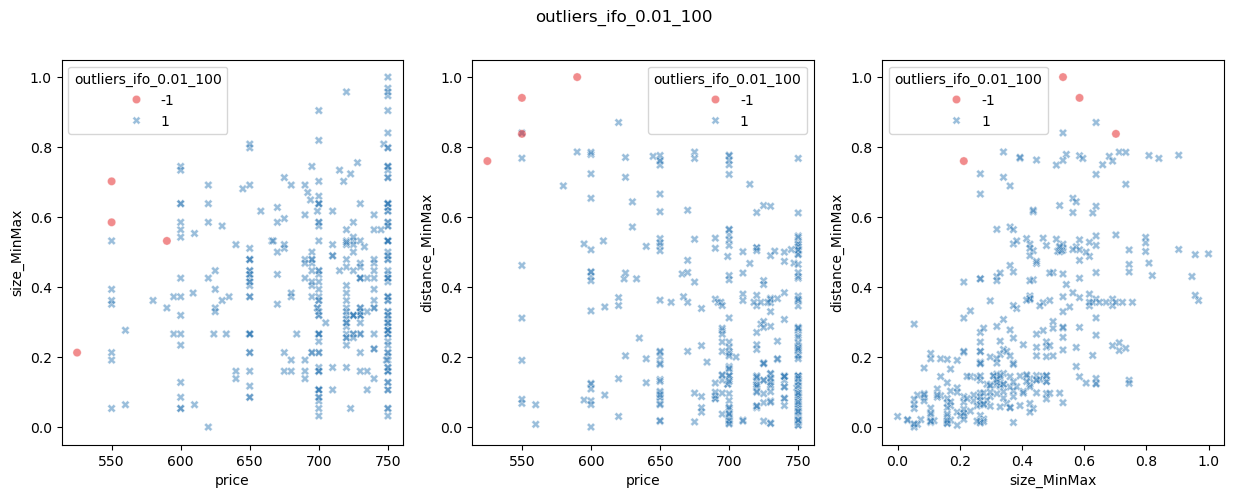

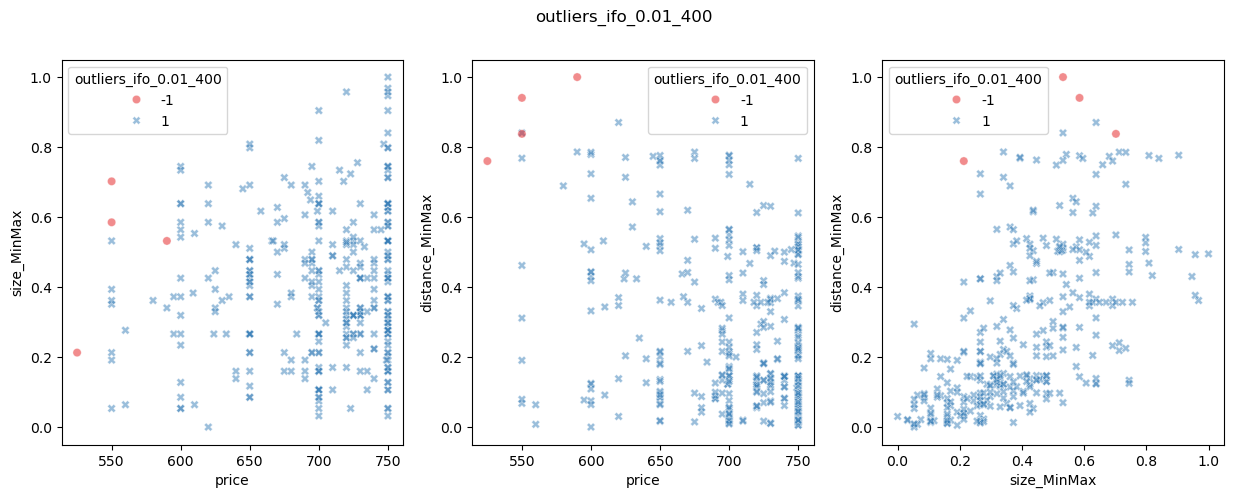

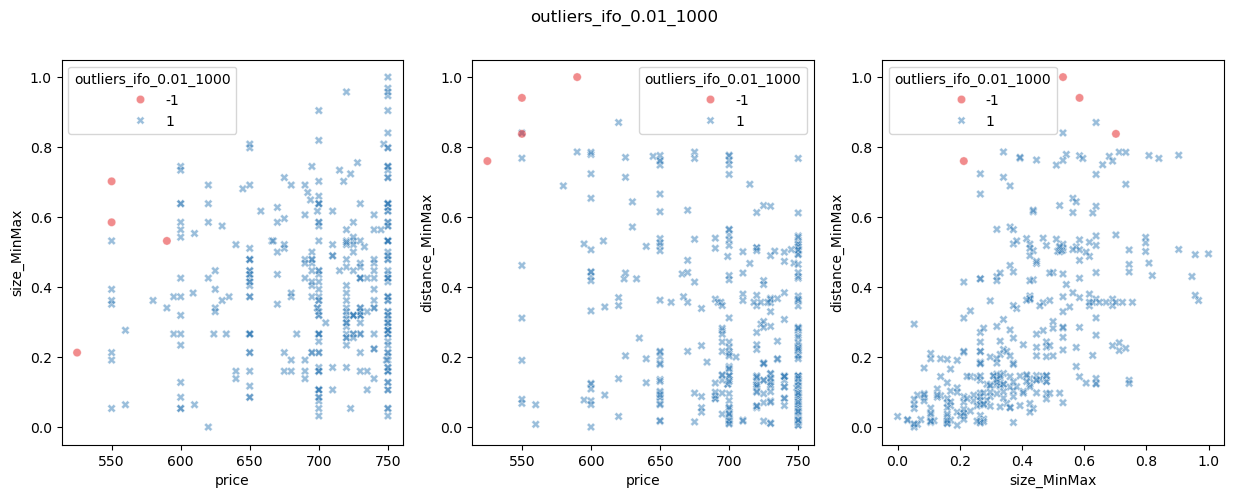

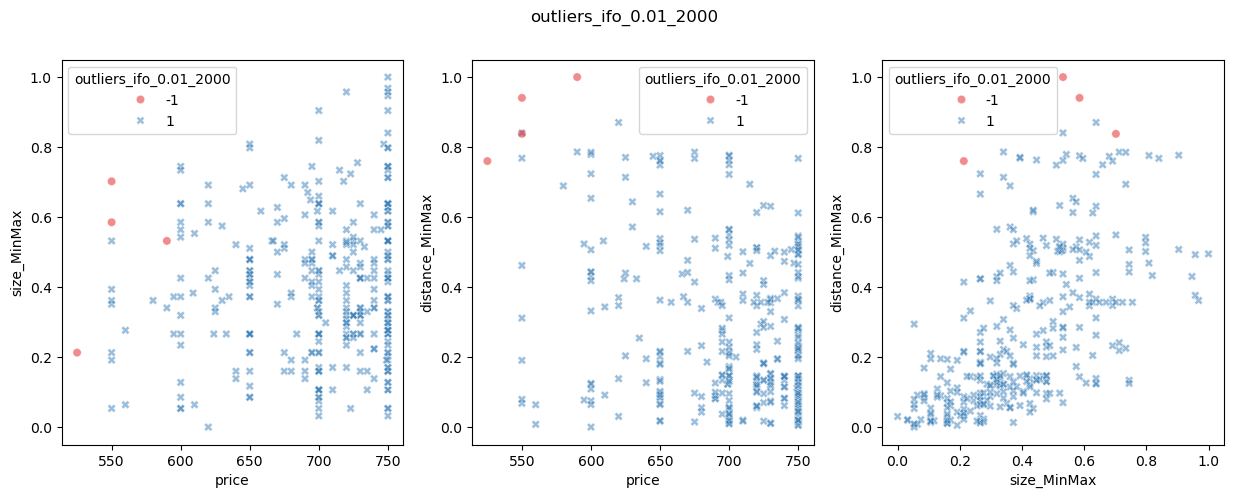

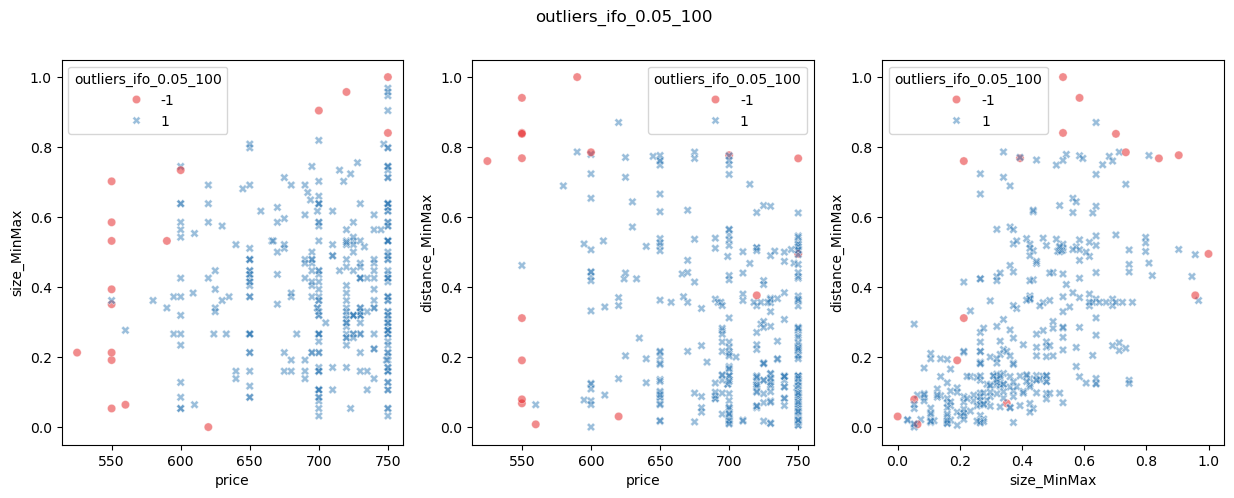

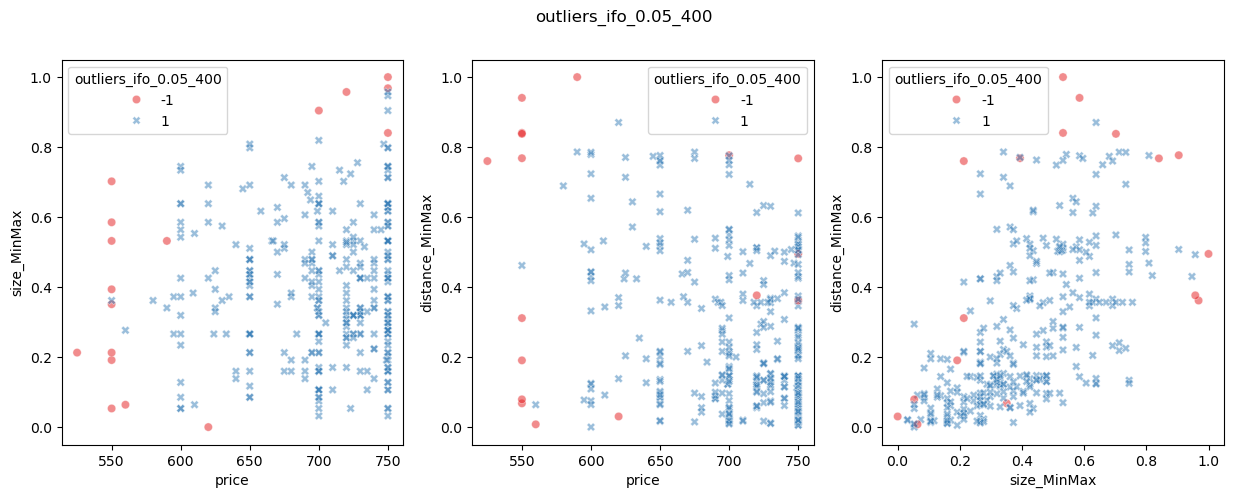

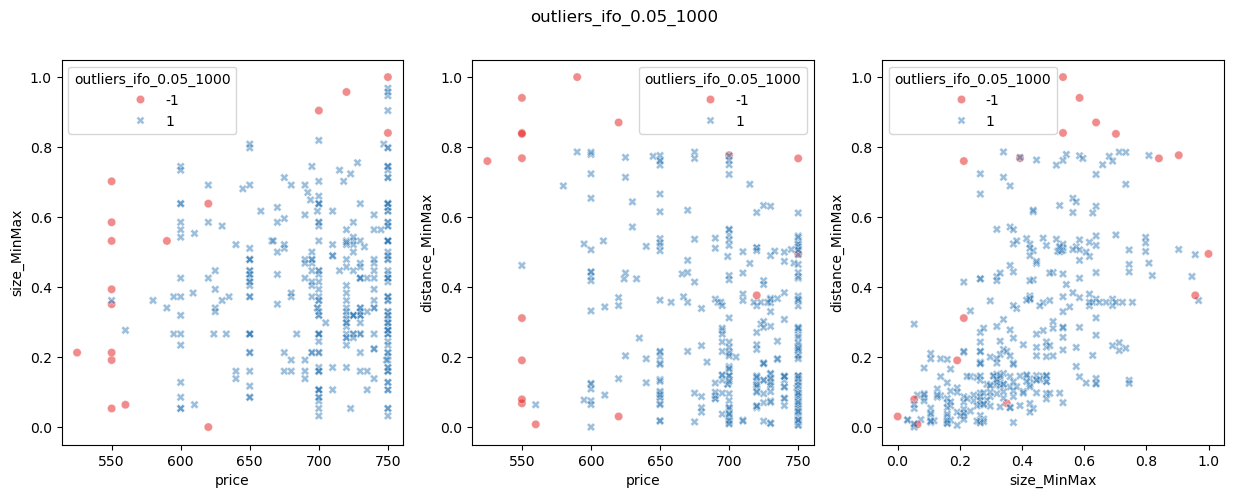

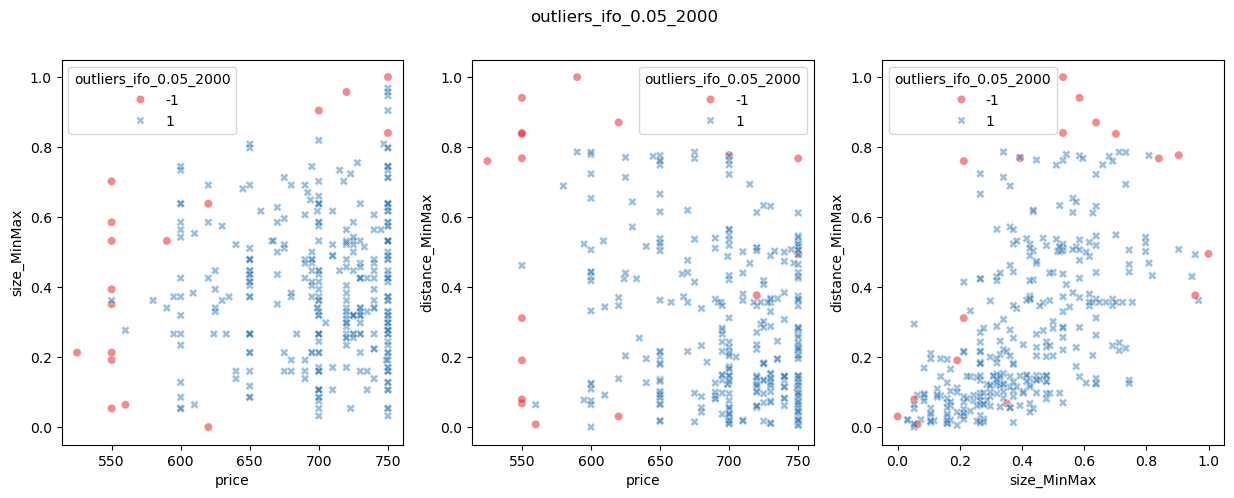

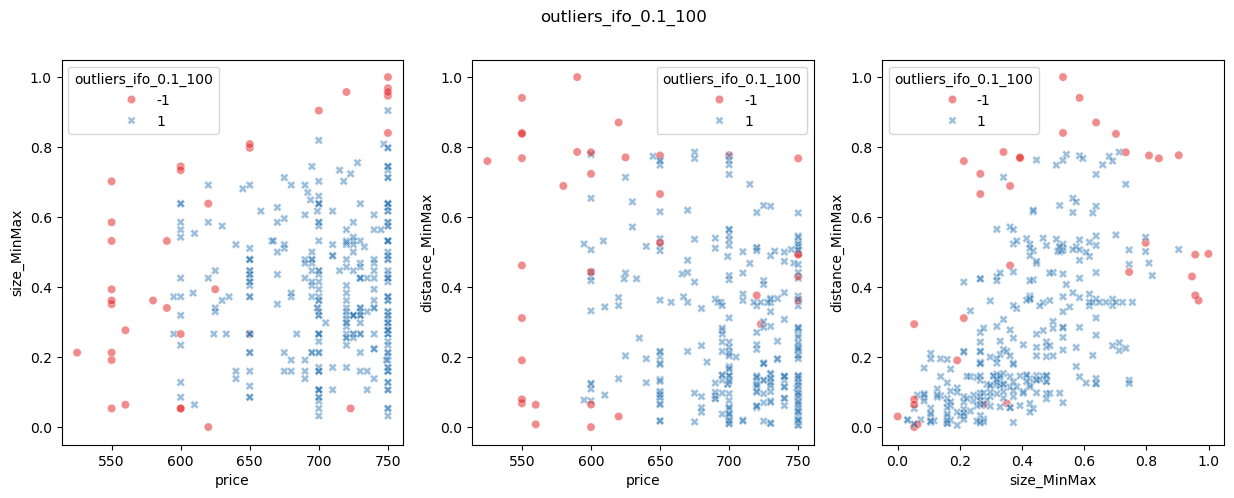

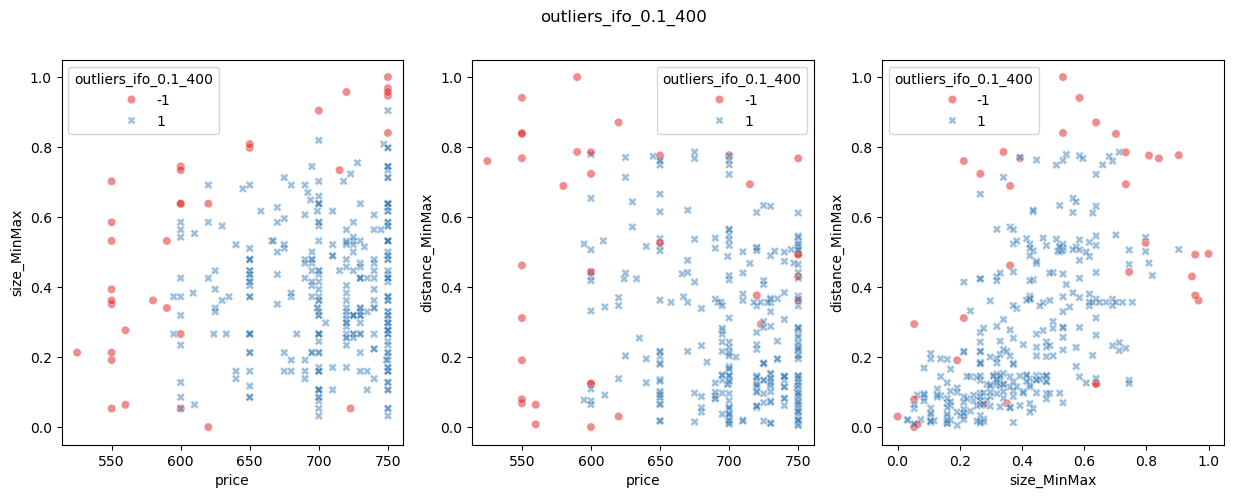

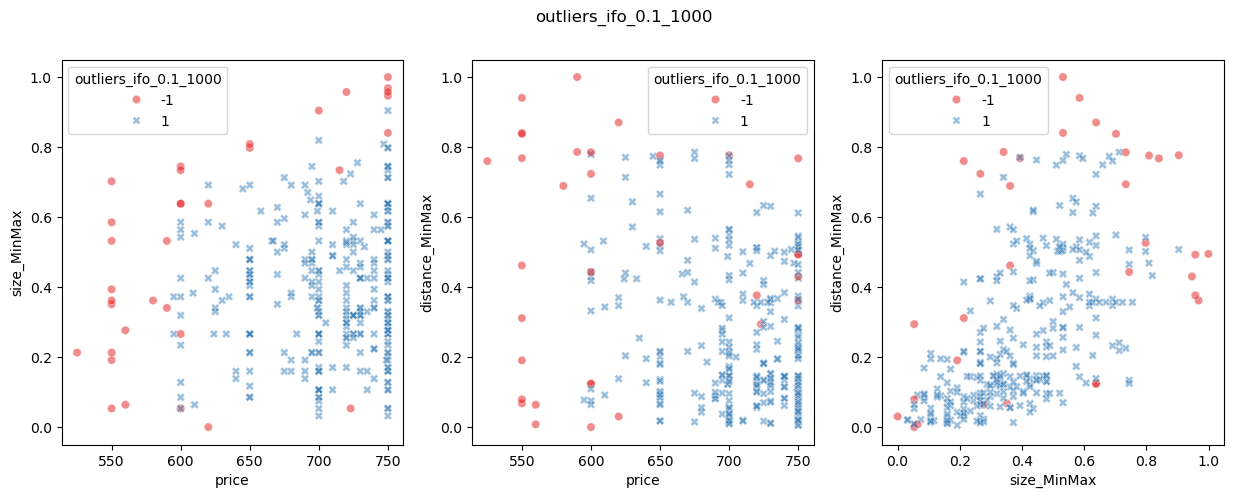

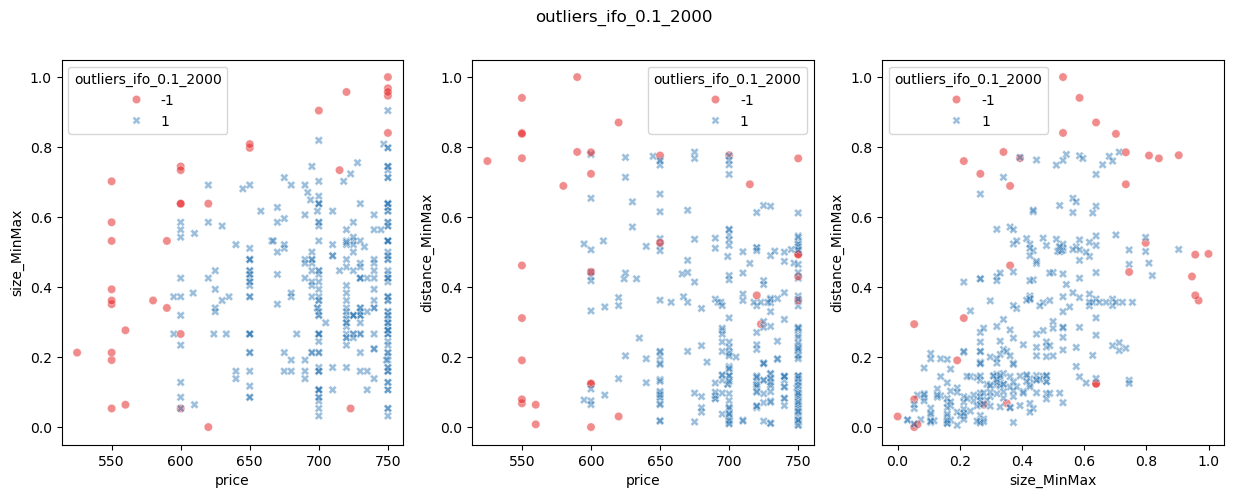

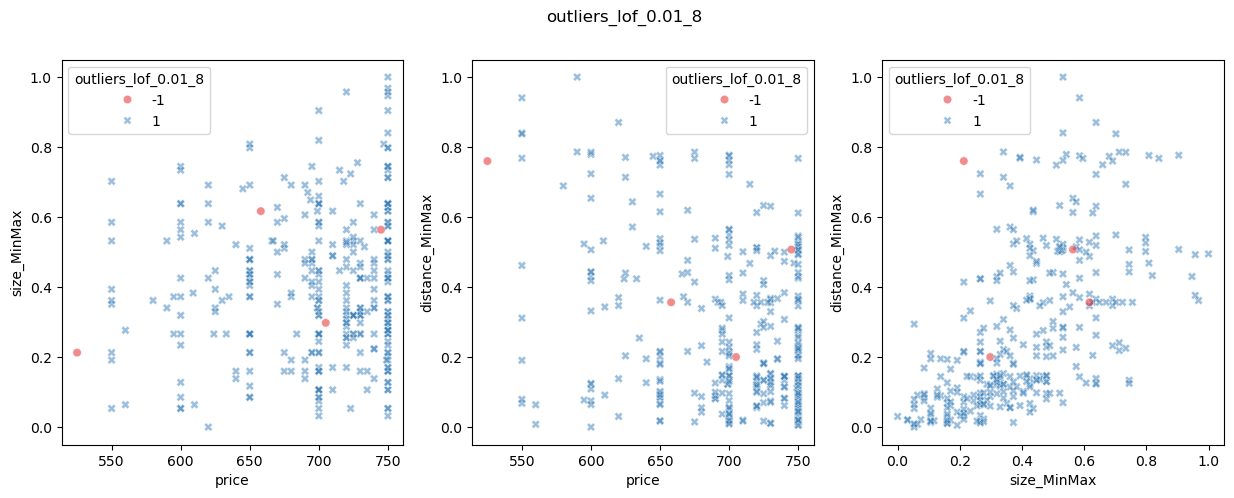

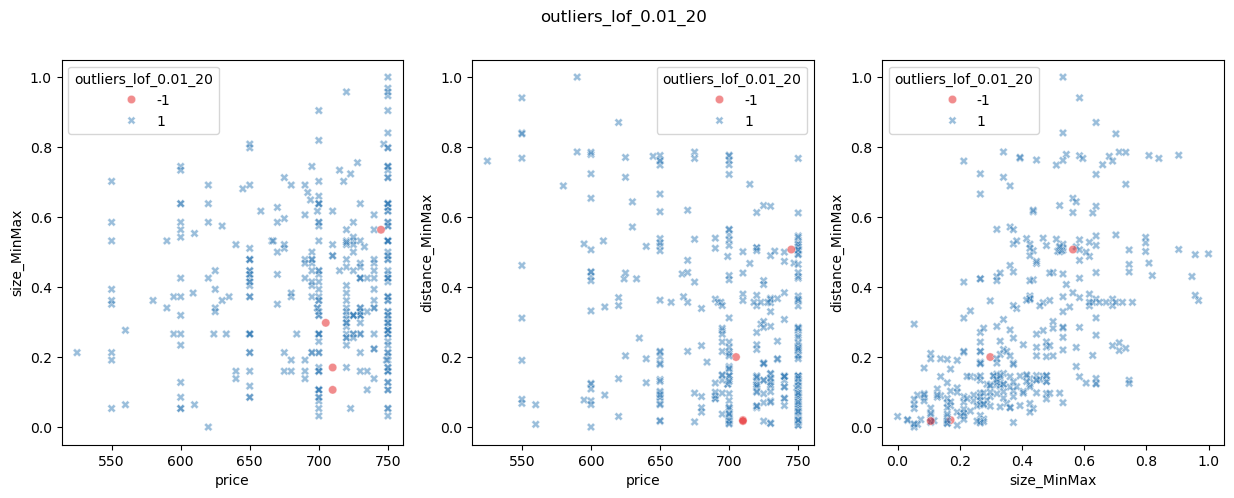

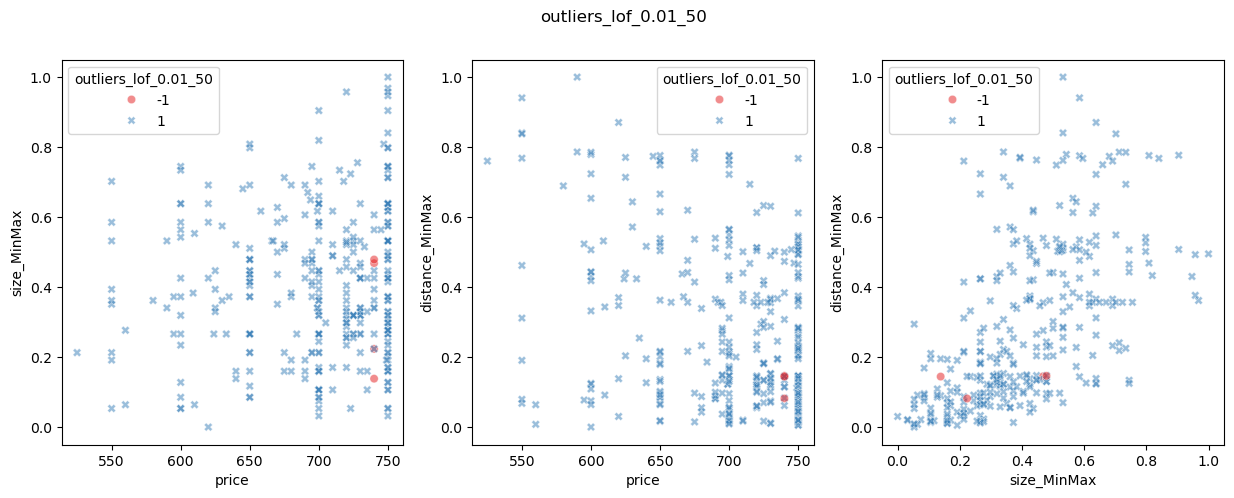

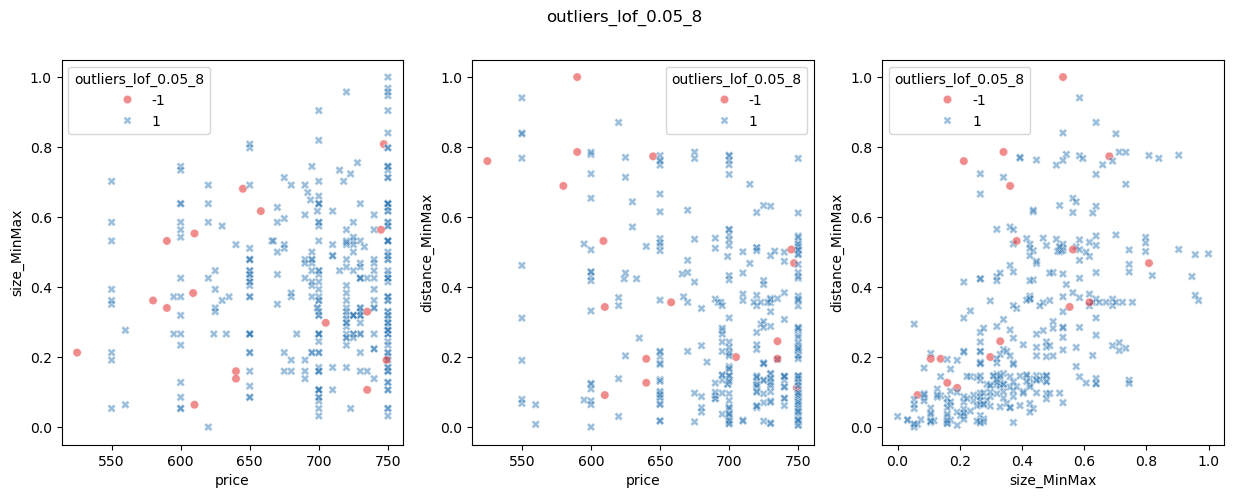

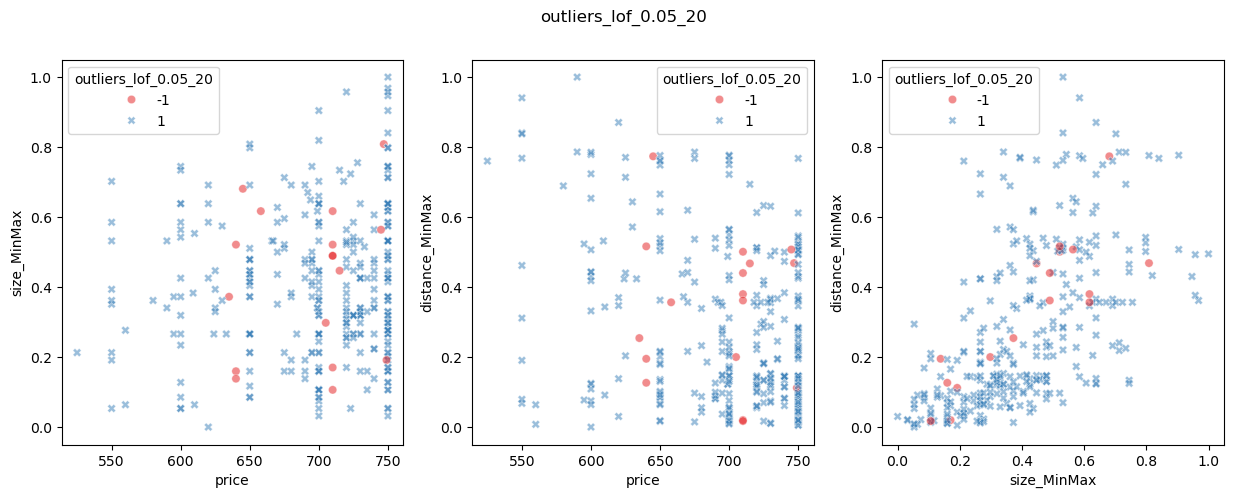

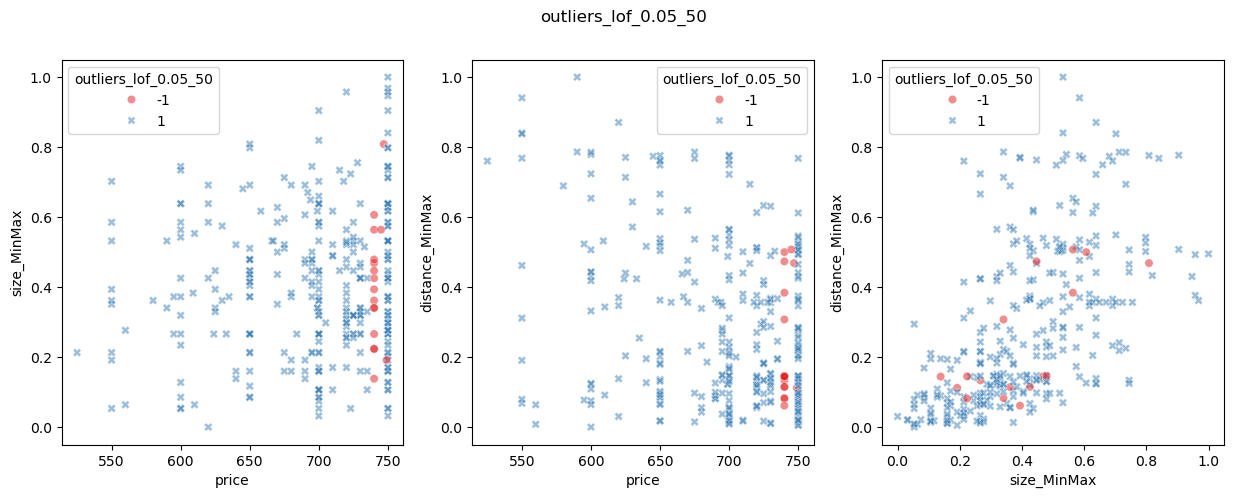

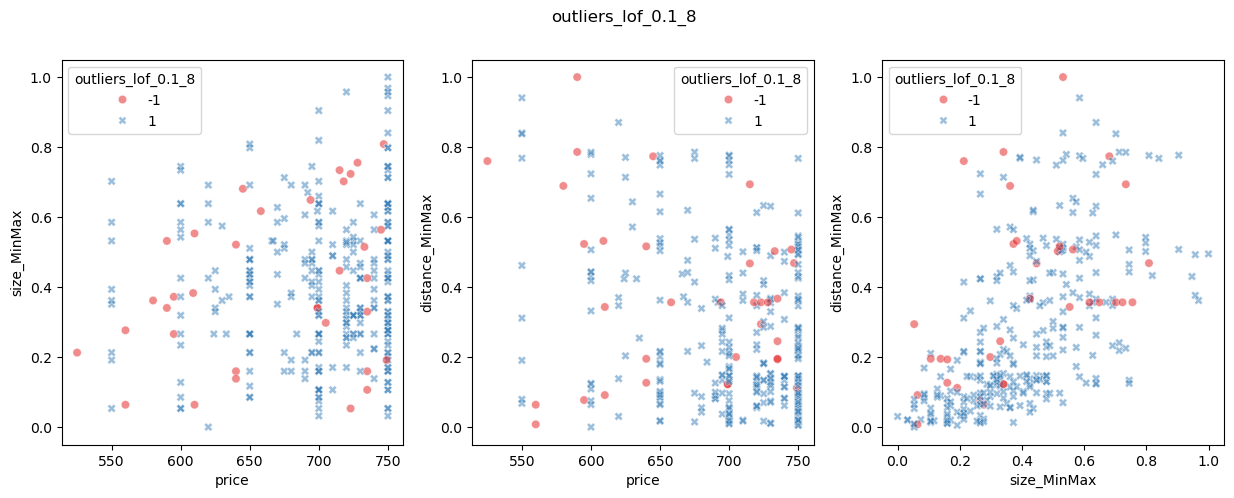

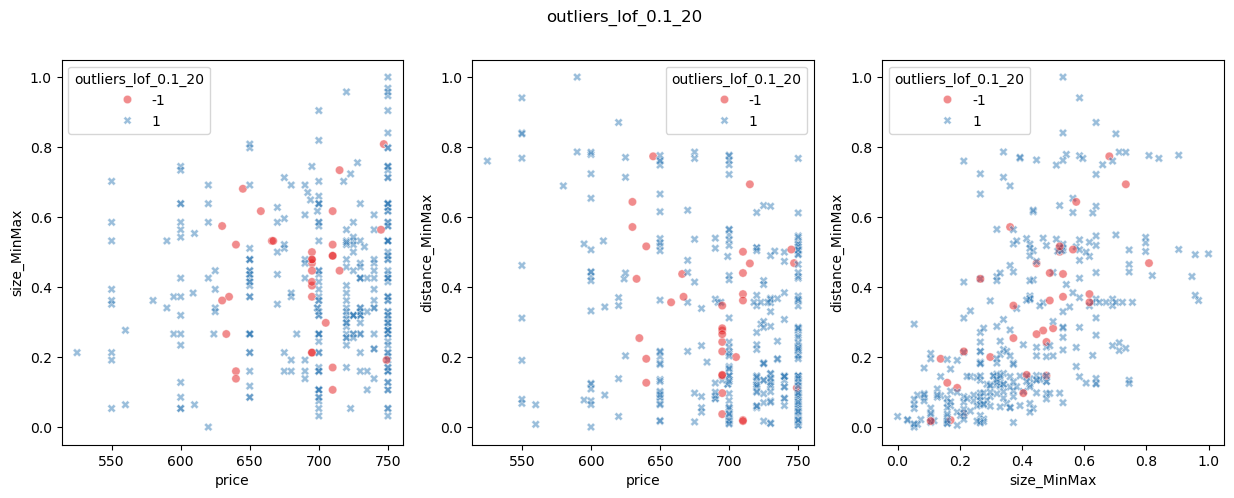

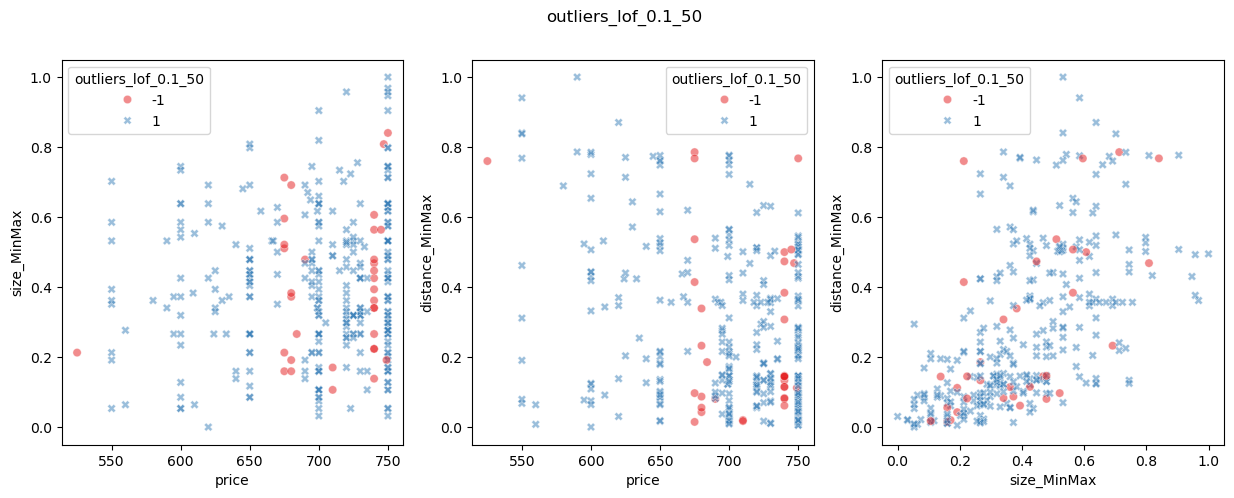

In [18]:
lista_contaminaciones = [0.01, 0.05, 0.1]
lista_neighbors = [8,20, 50]

combinaciones = list(product(lista_contaminaciones, lista_neighbors))
combinaciones


for cont, neighbors in tqdm(combinaciones):
    lof = LocalOutlierFactor(n_neighbors=neighbors,
                            contamination=cont,
                            n_jobs=-1)

    df_min[f"outliers_lof_{cont}_{neighbors}"] = lof.fit_predict(df_min[["price","size_MinMax","distance_MinMax"]])
    y_pred = lof.fit_predict(df_min[["price","size_MinMax","distance_MinMax"]])
df_min

#visualizacion
columnas_hue = df_min.filter(like="outlier").columns

combinaciones_viz = list(combinations(["price","size_MinMax","distance_MinMax"], 2))
combinaciones_viz

for outlier in tqdm(columnas_hue):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_viz):
        sns.scatterplot(x = tupla[0],
                        y = tupla[1],
                        ax = axes[indice],
                        data = df_min,
                        hue=outlier,
                        palette="Set1",
                        style=outlier,
                        alpha=0.5)
        
    plt.suptitle(outlier)

Lo que saco en claro es que el nivel de contaminación más estricto (10%) es la mejor opción porque es el que más se acerca a la realidad de los datos.  

Tras observar los gráficos del LOF observo que en el caso del tamaño, se consideran outliers aquellas viviendas que cuentan con un alto precio y según van aumentando su tamaño se va reduciendo el número de outliers. Por otro lado, al  observar la distancia nos percatamos de que de nuevo los outliers se concentran en los precios más altos lo que en un principio parece no tener sentido pues se mantienen aproximadamente igual distribuidos a lo largo de las distintas distancias. Sin embargo, no nos podemos fiar porque puede que esos datos sean outliers por otras variables que no sea la distancia.

Por el momento, me parece más adecuado hacer uso de la metodología IFO.


In [19]:
df_min.head()

price propertyType  exterior rooms bathrooms                municipality  \
0  750.0         flat      True     1         1                      Madrid   
1  750.0         flat      True     2         1  San Sebastián de los Reyes   
2  590.0         flat      True     3         2                   Rascafría   
3  684.0       studio      True     0         1                      Madrid   
4  600.0         flat      True     2         1          Manzanares el Real   

        status        floor      hasLift  size_MinMax  distance_MinMax  \
0         good            3         True     0.425532         0.121497   
1         good           bj        False     0.531915         0.282949   
2         good  desconocido        False     0.531915         1.000000   
3  desconocido  desconocido  desconocido     0.265957         0.185649   
4         good            3        False     0.563830         0.653732   

   outliers_ifo_0.01_100  outliers_ifo_0.01_400  outliers_ifo_0.01_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.01_2000  outliers_ifo_0.05_100  outliers_ifo_0.05_400  \
0                       1                      1                      1   
1                       1                      1                      1   
2                      -1                     -1                     -1   
3                       1                      1                      1   
4                       1                      1                      1   

   outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  outliers_ifo_0.1_100  \
0                       1                       1                     1   
1                       1                       1                     1   
2                      -1                      -1                    -1   
3                       1                       1                     1   
4                       1                       1                     1   

   outliers_ifo_0.1_400  outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  \
0                     1                      1                      1   
1                     1                      1                      1   
2                    -1                     -1                     -1   
3                     1                      1                      1   
4                     1                      1                      1   

   outliers_lof_0.01_8  outliers_lof_0.01_20  outliers_lof_0.01_50  \
0                    1                     1                     1   
1                    1                     1                     1   
2                    1                     1                     1   
3                    1                     1                     1   
4                    1                     1                     1   

   outliers_lof_0.05_8  outliers_lof_0.05_20  outliers_lof_0.05_50  \
0                    1                     1                     1   
1                    1                     1                     1   
2                   -1                     1                     1   
3                    1                     1                     1   
4                    1                     1                     1   

   outliers_lof_0.1_8  outliers_lof_0.1_20  outliers_lof_0.1_50  
0                   1                    1                    1  
1                   1                    1                    1  
2                  -1                    1                    1  
3                   1                    1                   -1  
4                   1                    1                    1

In [20]:
df_min.columns

Index(['price', 'propertyType', 'exterior', 'rooms', 'bathrooms',
       'municipality', 'status', 'floor', 'hasLift', 'size_MinMax',
       'distance_MinMax', 'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000', 'outliers_lof_0.01_8', 'outliers_lof_0.01_20',
       'outliers_lof_0.01_50', 'outliers_lof_0.05_8', 'outliers_lof_0.05_20',
       'outliers_lof_0.05_50', 'outliers_lof_0.1_8', 'outliers_lof_0.1_20',
       'outliers_lof_0.1_50'],
      dtype='object')

In [21]:
df_ifo=df_min[['price', 'propertyType', 'exterior', 'rooms', 'bathrooms',
       'municipality', 'status', 'floor',
       'hasLift', 'size_MinMax', 'distance_MinMax',
       'outliers_ifo_0.01_100', 'outliers_ifo_0.01_400',
       'outliers_ifo_0.01_1000', 'outliers_ifo_0.01_2000',
       'outliers_ifo_0.05_100', 'outliers_ifo_0.05_400',
       'outliers_ifo_0.05_1000', 'outliers_ifo_0.05_2000',
       'outliers_ifo_0.1_100', 'outliers_ifo_0.1_400', 'outliers_ifo_0.1_1000',
       'outliers_ifo_0.1_2000']]

In [22]:
df_ifo.head()

price propertyType  exterior rooms bathrooms                municipality  \
0  750.0         flat      True     1         1                      Madrid   
1  750.0         flat      True     2         1  San Sebastián de los Reyes   
2  590.0         flat      True     3         2                   Rascafría   
3  684.0       studio      True     0         1                      Madrid   
4  600.0         flat      True     2         1          Manzanares el Real   

        status        floor      hasLift  size_MinMax  distance_MinMax  \
0         good            3         True     0.425532         0.121497   
1         good           bj        False     0.531915         0.282949   
2         good  desconocido        False     0.531915         1.000000   
3  desconocido  desconocido  desconocido     0.265957         0.185649   
4         good            3        False     0.563830         0.653732   

   outliers_ifo_0.01_100  outliers_ifo_0.01_400  outliers_ifo_0.01_1000  \
0                      1                      1                       1   
1                      1                      1                       1   
2                     -1                     -1                      -1   
3                      1                      1                       1   
4                      1                      1                       1   

   outliers_ifo_0.01_2000  outliers_ifo_0.05_100  outliers_ifo_0.05_400  \
0                       1                      1                      1   
1                       1                      1                      1   
2                      -1                     -1                     -1   
3                       1                      1                      1   
4                       1                      1                      1   

   outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  outliers_ifo_0.1_100  \
0                       1                       1                     1   
1                       1                       1                     1   
2                      -1                      -1                    -1   
3                       1                       1                     1   
4                       1                       1                     1   

   outliers_ifo_0.1_400  outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
0                     1                      1                      1  
1                     1                      1                      1  
2                    -1                     -1                     -1  
3                     1                      1                      1  
4                     1                      1                      1

Ahora me quito las que tengan todas las filas con 1 y así me quedo con todas las que al menos tienen un Outlier

In [23]:
columnasdf=df_min.filter(like="outliers_ifo")
columnas_ifo=columnasdf.columns

In [24]:

filtered_df = df_ifo[(df_ifo[columnas_ifo] == -1).all(axis=1)]

In [25]:
filtered_df

price propertyType  exterior rooms bathrooms     municipality status  \
2    590.0         flat      True     3         2        Rascafría   good   
182  550.0    penthouse      True     2         2  Villa del Prado   good   
253  525.0         flat      True     1         1         Aranjuez   good   
335  550.0         flat      True     2         1      Torrelaguna   good   

           floor hasLift  size_MinMax  distance_MinMax  outliers_ifo_0.01_100  \
2    desconocido   False     0.531915         1.000000                     -1   
182  desconocido   False     0.585106         0.940634                     -1   
253            3    True     0.212766         0.760038                     -1   
335            1    True     0.702128         0.837839                     -1   

     outliers_ifo_0.01_400  outliers_ifo_0.01_1000  outliers_ifo_0.01_2000  \
2                       -1                      -1                      -1   
182                     -1                      -1                      -1   
253                     -1                      -1                      -1   
335                     -1                      -1                      -1   

     outliers_ifo_0.05_100  outliers_ifo_0.05_400  outliers_ifo_0.05_1000  \
2                       -1                     -1                      -1   
182                     -1                     -1                      -1   
253                     -1                     -1                      -1   
335                     -1                     -1                      -1   

     outliers_ifo_0.05_2000  outliers_ifo_0.1_100  outliers_ifo_0.1_400  \
2                        -1                    -1                    -1   
182                      -1                    -1                    -1   
253                      -1                    -1                    -1   
335                      -1                    -1                    -1   

     outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
2                       -1                     -1  
182                     -1                     -1  
253                     -1                     -1  
335                     -1                     -1

In [26]:
filtered_df.shape

(4, 23)

Al observar las filas que tienen todos los valores con -1 y observar que suponen una parte ínfima de los datos, se decide eliminarlos

In [27]:
df_result = df_ifo.drop(index = filtered_df.index)

In [28]:
df_result.reset_index(drop=True, inplace=True)

In [29]:
df_result.shape

(337, 23)

Ahora seleccionamos el 60% de los outliers

In [30]:
proporcion = 0.6 * len(columnas_ifo)
df_outliers_60 = df_result[df_result[columnas_ifo].eq(-1).sum(axis=1) >= proporcion]


In [31]:
df_ifo.shape

(341, 23)

In [32]:
df_outliers_60.shape

(12, 23)

Observamos la distancia

In [33]:
df_outliers_60["distance_MinMax"].shape

(12,)

In [35]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0.8]["distance_MinMax"]

241    0.840445
Name: distance_MinMax, dtype: float64

In [36]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0.8]["distance_MinMax"].shape

(1,)

In [37]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0]["distance_MinMax"].unique()

array([0.06780352, 0.77677131, 0.76771312, 0.19064755, 0.31139985,
       0.00783507, 0.3764026 , 0.76822718, 0.84044458, 0.03031216,
       0.07918388, 0.49485048])

Estamos observando los valores mayores a 0.9 (aproximadamente a partir de 55 kilometros del centro)

In [38]:
df_outliers_60.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 5 to 305
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   12 non-null     float64
 1   propertyType            12 non-null     object 
 2   exterior                12 non-null     bool   
 3   rooms                   12 non-null     object 
 4   bathrooms               12 non-null     object 
 5   municipality            12 non-null     object 
 6   status                  12 non-null     object 
 7   floor                   12 non-null     object 
 8   hasLift                 12 non-null     object 
 9   size_MinMax             12 non-null     float64
 10  distance_MinMax         12 non-null     float64
 11  outliers_ifo_0.01_100   12 non-null     int32  
 12  outliers_ifo_0.01_400   12 non-null     int32  
 13  outliers_ifo_0.01_1000  12 non-null     int32  
 14  outliers_ifo_0.01_2000  12 non-null     int32  


In [39]:
df_outliers_60["distance_MinMax"].min()

0.0078350734759718

In [40]:
df_outliers_60["distance_MinMax"].max()

0.8404445783773244

In [41]:
df_outliers_60[df_outliers_60["distance_MinMax"] > 0].shape

(12, 23)

In [42]:
df_outliers_60["distance_MinMax"].shape

(12,)

Aqui quiero crear el intervalo de outliers con el que me voy a quedar.  
Dado que las viviendas con un valor de distancia mayor a 0.9 (unos 55km aproximadamente del centro) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [43]:
df_outliers_60=df_outliers_60[(df_outliers_60["distance_MinMax"] > 0 ) & (df_outliers_60["distance_MinMax"] < 0.8)]

Casi la mitad de otliers se encuentra entre 0.8 y 1 (45 y 60 kilometros de distancia aproximadamente). Esto muestra que hay otra mitad de viviendas (outliers) entre los 0 km y los 55 km aproximadamente cosa que tiene sentido con lo que no puedo eliminar estos outliers.El resto si que no tiene sentido mantenerlos (>0.8)

Ahora observamos los tamaños

In [44]:
df_outliers_60["size_MinMax"].shape

(11,)

In [45]:
df_outliers_60["size_MinMax"].unique()

array([0.35106383, 0.90425532, 0.84042553, 0.19148936, 0.21276596,
       0.06382979, 0.95744681, 0.39361702, 0.        , 0.05319149,
       1.        ])


En los outliers de size: media(0.47) y mediana (0.39) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:1 o 0.85271318)  
En los outliers de distance: media(0.52) y mediana (0.57) indica que en los outliers hay valores atípicos que distorsionan la media (Ej:0.00739922 o 0.00980983)  

In [46]:
pd.options.display.float_format = "{:,.2f}".format 
df_outliers_60.describe().T

count   mean   std    min    25%    50%    75%    max
price                   11.00 622.73 88.44 550.00 550.00 560.00 710.00 750.00
size_MinMax             11.00   0.45  0.40   0.00   0.13   0.35   0.87   1.00
distance_MinMax         11.00   0.35  0.31   0.01   0.07   0.31   0.63   0.78
outliers_ifo_0.01_100   11.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_400   11.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_1000  11.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_2000  11.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_100   11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.05_400   11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.05_1000  11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.05_2000  11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_100    11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_400    11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_1000   11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00
outliers_ifo_0.1_2000   11.00  -1.00  0.00  -1.00  -1.00  -1.00  -1.00  -1.00

In [49]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.8]["size_MinMax"].unique()

array([0.90425532, 0.84042553, 0.95744681, 1.        ])

In [50]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.8].shape

(4, 23)

In [51]:
df_outliers_60[df_outliers_60["size_MinMax"] > 0.8]

price propertyType  exterior rooms bathrooms           municipality  \
16  700.00         flat      True     3         2               Aranjuez   
20  750.00         flat      True     3         2               Aranjuez   
215 720.00         flat     False     2         1                  Parla   
305 750.00       duplex      True     3         3  Serranillos del Valle   

    status        floor hasLift  size_MinMax  distance_MinMax  \
16    good           bj   False         0.90             0.78   
20    good            1    True         0.84             0.77   
215   good  desconocido    True         0.96             0.38   
305   good            1   False         1.00             0.49   

     outliers_ifo_0.01_100  outliers_ifo_0.01_400  outliers_ifo_0.01_1000  \
16                       1                      1                       1   
20                       1                      1                       1   
215                      1                      1                       1   
305                      1                      1                       1   

     outliers_ifo_0.01_2000  outliers_ifo_0.05_100  outliers_ifo_0.05_400  \
16                        1                     -1                     -1   
20                        1                     -1                     -1   
215                       1                     -1                     -1   
305                       1                     -1                     -1   

     outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  outliers_ifo_0.1_100  \
16                       -1                      -1                    -1   
20                       -1                      -1                    -1   
215                      -1                      -1                    -1   
305                      -1                      -1                    -1   

     outliers_ifo_0.1_400  outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
16                     -1                     -1                     -1  
20                     -1                     -1                     -1  
215                    -1                     -1                     -1  
305                    -1                     -1                     -1

In [53]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.8].shape

(7, 23)

In [54]:
df_outliers_60[df_outliers_60["size_MinMax"] < 0.8]

price propertyType  exterior rooms bathrooms           municipality  \
5   550.00         flat      True     1         1                 Madrid   
44  550.00         flat      True     1         1                Leganés   
63  550.00         flat      True     1         1  Paracuellos de Jarama   
130 560.00         flat     False     1         1                 Madrid   
222 550.00         flat     False     2         1               Aranjuez   
266 620.00       studio     False     0         1                 Madrid   
280 550.00       studio     False     0         1                 Madrid   

    status        floor hasLift  size_MinMax  distance_MinMax  \
5     good            1   False         0.35             0.07   
44    good  desconocido   False         0.19             0.19   
63    good            3    True         0.21             0.31   
130   good           bj   False         0.06             0.01   
222   good           bj   False         0.39             0.77   
266   good            1    True         0.00             0.03   
280   good           bj   False         0.05             0.08   

     outliers_ifo_0.01_100  outliers_ifo_0.01_400  outliers_ifo_0.01_1000  \
5                        1                      1                       1   
44                       1                      1                       1   
63                       1                      1                       1   
130                      1                      1                       1   
222                      1                      1                       1   
266                      1                      1                       1   
280                      1                      1                       1   

     outliers_ifo_0.01_2000  outliers_ifo_0.05_100  outliers_ifo_0.05_400  \
5                         1                     -1                     -1   
44                        1                     -1                     -1   
63                        1                     -1                     -1   
130                       1                     -1                     -1   
222                       1                     -1                     -1   
266                       1                     -1                     -1   
280                       1                     -1                     -1   

     outliers_ifo_0.05_1000  outliers_ifo_0.05_2000  outliers_ifo_0.1_100  \
5                        -1                      -1                    -1   
44                       -1                      -1                    -1   
63                       -1                      -1                    -1   
130                      -1                      -1                    -1   
222                      -1                      -1                    -1   
266                      -1                      -1                    -1   
280                      -1                      -1                    -1   

     outliers_ifo_0.1_400  outliers_ifo_0.1_1000  outliers_ifo_0.1_2000  
5                      -1                     -1                     -1  
44                     -1                     -1                     -1  
63                     -1                     -1                     -1  
130                    -1                     -1                     -1  
222                    -1                     -1                     -1  
266                    -1                     -1                     -1  
280                    -1                     -1                     -1

Aqui quiero crear el intervalo de outliers con el que me voy a quedar de size  
Dado que las viviendas con un valor de size menor a 0.35 (75 metros cuadrados aproximadamente) y mayor a 0.84 (135 metros cuadrados aproximadamente) me las marca por lo general como outliers y dado que no hay muchas se eliminan, para el resto se tratará de imputar su valor.

In [55]:
df_outliers_60=df_outliers_60[df_outliers_60["size_MinMax"] < 0.8]

In [56]:
df_outliers_60.shape

(7, 23)

Ahora a que ya hemos analizado los outliers decidimos imputarlos usando KNN con lo que primero pasamos todos a nan y los meto en el dataframe completo donde voy a querer meter el imputer KNN (y probaremos con el iterative también)

In [57]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   337 non-null    float64
 1   propertyType            337 non-null    object 
 2   exterior                337 non-null    bool   
 3   rooms                   337 non-null    object 
 4   bathrooms               337 non-null    object 
 5   municipality            337 non-null    object 
 6   status                  337 non-null    object 
 7   floor                   337 non-null    object 
 8   hasLift                 337 non-null    object 
 9   size_MinMax             337 non-null    float64
 10  distance_MinMax         337 non-null    float64
 11  outliers_ifo_0.01_100   337 non-null    int32  
 12  outliers_ifo_0.01_400   337 non-null    int32  
 13  outliers_ifo_0.01_1000  337 non-null    int32  
 14  outliers_ifo_0.01_2000  337 non-null    in

In [58]:
df_result.loc[df_outliers_60.index, "size_MinMax"] = np.nan
df_result.loc[df_outliers_60.index, "distance_MinMax"] = np.nan

In [59]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   337 non-null    float64
 1   propertyType            337 non-null    object 
 2   exterior                337 non-null    bool   
 3   rooms                   337 non-null    object 
 4   bathrooms               337 non-null    object 
 5   municipality            337 non-null    object 
 6   status                  337 non-null    object 
 7   floor                   337 non-null    object 
 8   hasLift                 337 non-null    object 
 9   size_MinMax             330 non-null    float64
 10  distance_MinMax         330 non-null    float64
 11  outliers_ifo_0.01_100   337 non-null    int32  
 12  outliers_ifo_0.01_400   337 non-null    int32  
 13  outliers_ifo_0.01_1000  337 non-null    int32  
 14  outliers_ifo_0.01_2000  337 non-null    in

In [60]:
df_numericas=df_result.select_dtypes(include=np.number)
imputer_knn= KNNImputer(n_neighbors=5)   #por defecto siempre lo calcula en base a la media y no se puede cambiar
knn_imputado= imputer_knn.fit_transform(df_numericas)    #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_knn=df_result.copy()
df_num_sin_nulos=pd.DataFrame(knn_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_knn[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos


In [61]:
df_knn.isna().sum()

price                     0
propertyType              0
exterior                  0
rooms                     0
bathrooms                 0
municipality              0
status                    0
floor                     0
hasLift                   0
size_MinMax               0
distance_MinMax           0
outliers_ifo_0.01_100     0
outliers_ifo_0.01_400     0
outliers_ifo_0.01_1000    0
outliers_ifo_0.01_2000    0
outliers_ifo_0.05_100     0
outliers_ifo_0.05_400     0
outliers_ifo_0.05_1000    0
outliers_ifo_0.05_2000    0
outliers_ifo_0.1_100      0
outliers_ifo_0.1_400      0
outliers_ifo_0.1_1000     0
outliers_ifo_0.1_2000     0
dtype: int64

In [64]:
df_knn.describe().T

count   mean   std    min    25%    50%    75%    max
price                  337.00 699.09 51.47 550.00 670.00 710.00 750.00 750.00
size_MinMax            337.00   0.41  0.20   0.03   0.27   0.37   0.53   1.00
distance_MinMax        337.00   0.28  0.22   0.00   0.10   0.21   0.44   0.87
outliers_ifo_0.01_100  337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_400  337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_1000 337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_2000 337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_100  337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_400  337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_1000 337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_2000 337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_100   337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_400   337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_1000  337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_2000  337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00

In [69]:
df_knn.to_csv("../../datos/datos2/datos_sin_outliers.csv")

In [70]:
df=pd.read_csv("../../datos/datos2/datos_sin_outliers.csv", index_col=0).reset_index(drop=True)

In [71]:
df_filt=df[["price", "size_MinMax", "distance_MinMax"]]

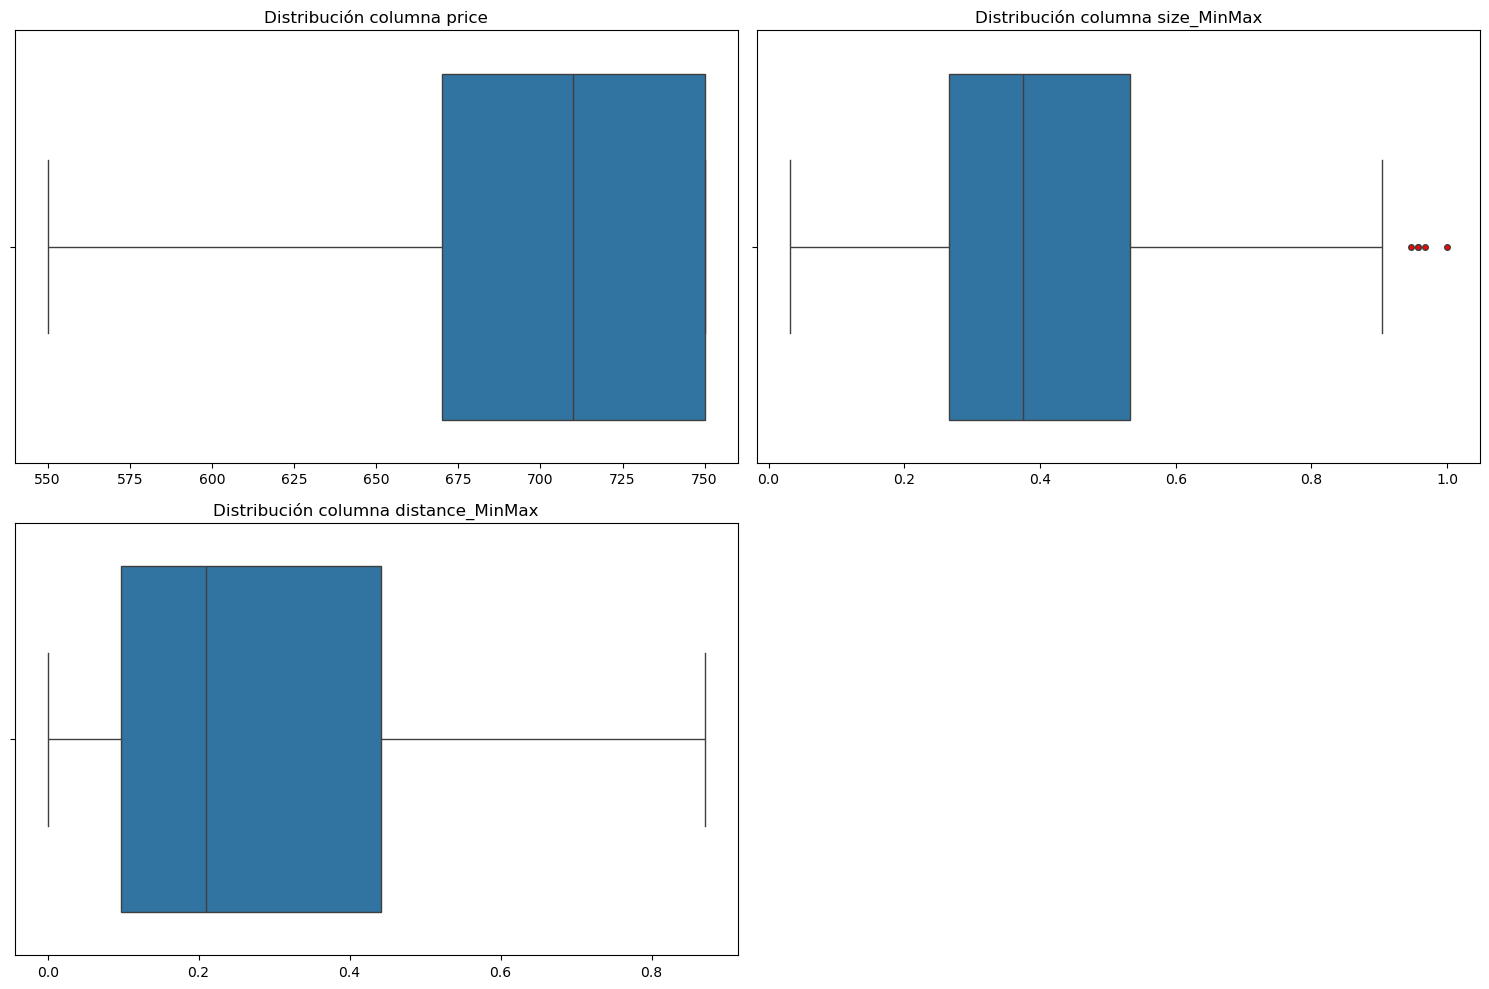

In [72]:
f.plot_outliers_univariados(df_filt, "b", (15,10))

In [73]:
df_est_con3=df_min[["price", "size_MinMax", "distance_MinMax"]]

In [74]:
(df_filt["size_MinMax"]> 0.8).sum()

11

In [75]:
(df_est_con3["size_MinMax"]> 0.8).sum()

11

In [78]:
(df_filt["price"]< 500).sum()

0

In [79]:
(df_est_con3["price"]< 500).sum()

0

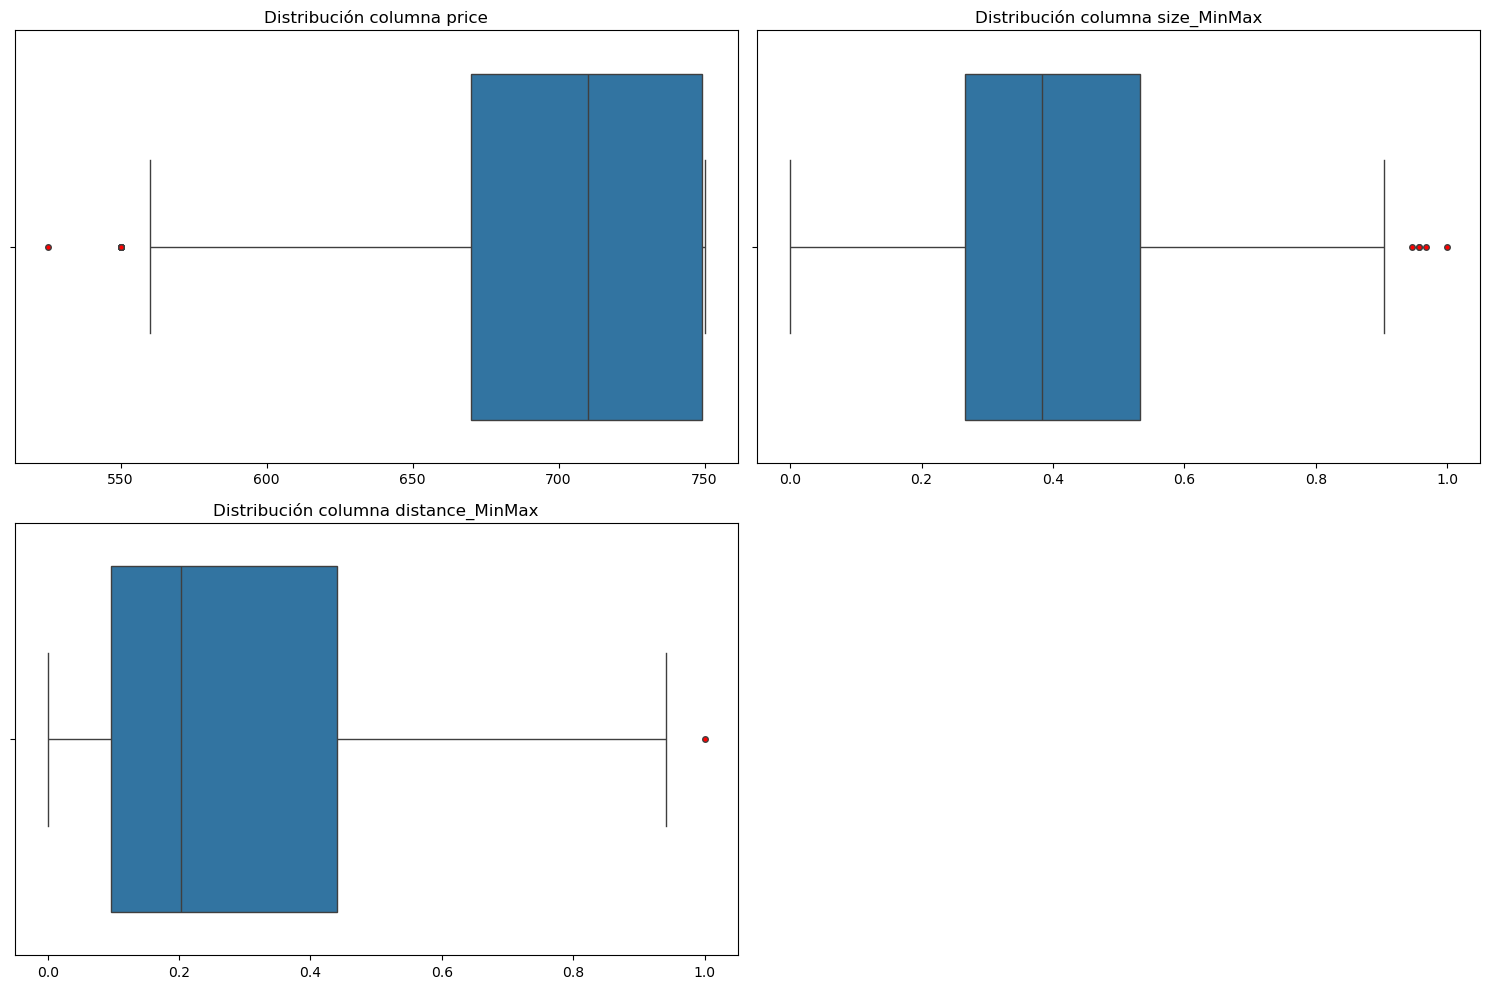

In [80]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

caso con iterative

In [81]:
df_numericas=df_result.select_dtypes(include=np.number)
df_numericas.drop(columns="price", inplace=True)
imputer_iterative= IterativeImputer()       #Aquí se puede poner el KNNImputer o el RandomForestRegressor
                                            #missing values es por si los nulos no estan como np.nan sino en texto por ejemplo (aunque lo suyo es limpiarlo en el EDA)
                                            #initial_strategy= "median" sirve para indicar que me lo haga con las medianas
iterative_imputado=imputer_iterative.fit_transform(df_numericas)   #como es solo para numericas se tiene que meter el df de numericas pero hay que definirlo otra vez porque hemos dropeado duplicados
df_iterativo=df_result.copy()
df_num_sin_nulos=pd.DataFrame(iterative_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_iterativo[df_numericas.columns]= df_num_sin_nulos    #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos

In [82]:
df_iterativo.isna().sum()

price                     0
propertyType              0
exterior                  0
rooms                     0
bathrooms                 0
municipality              0
status                    0
floor                     0
hasLift                   0
size_MinMax               0
distance_MinMax           0
outliers_ifo_0.01_100     0
outliers_ifo_0.01_400     0
outliers_ifo_0.01_1000    0
outliers_ifo_0.01_2000    0
outliers_ifo_0.05_100     0
outliers_ifo_0.05_400     0
outliers_ifo_0.05_1000    0
outliers_ifo_0.05_2000    0
outliers_ifo_0.1_100      0
outliers_ifo_0.1_400      0
outliers_ifo_0.1_1000     0
outliers_ifo_0.1_2000     0
dtype: int64

In [83]:
df_iterativo.describe().T

count   mean   std    min    25%    50%    75%    max
price                  337.00 699.09 51.47 550.00 670.00 710.00 750.00 750.00
size_MinMax            337.00   0.42  0.21   0.03   0.27   0.39   0.54   1.00
distance_MinMax        337.00   0.28  0.22   0.00   0.10   0.21   0.44   0.87
outliers_ifo_0.01_100  337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_400  337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_1000 337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.01_2000 337.00   1.00  0.00   1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_100  337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_400  337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_1000 337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.05_2000 337.00   0.92  0.39  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_100   337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_400   337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_1000  337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00
outliers_ifo_0.1_2000  337.00   0.82  0.57  -1.00   1.00   1.00   1.00   1.00

In [84]:
df_iterativo.to_csv("../../datos/datos2/datos_sin_outliers_iterativo.csv")

In [85]:
df_it=pd.read_csv("../../datos/datos2/datos_sin_outliers_iterativo.csv", index_col=0).reset_index(drop=True)

In [86]:
df_filt_it=df_it[["price", "size_MinMax", "distance_MinMax"]]

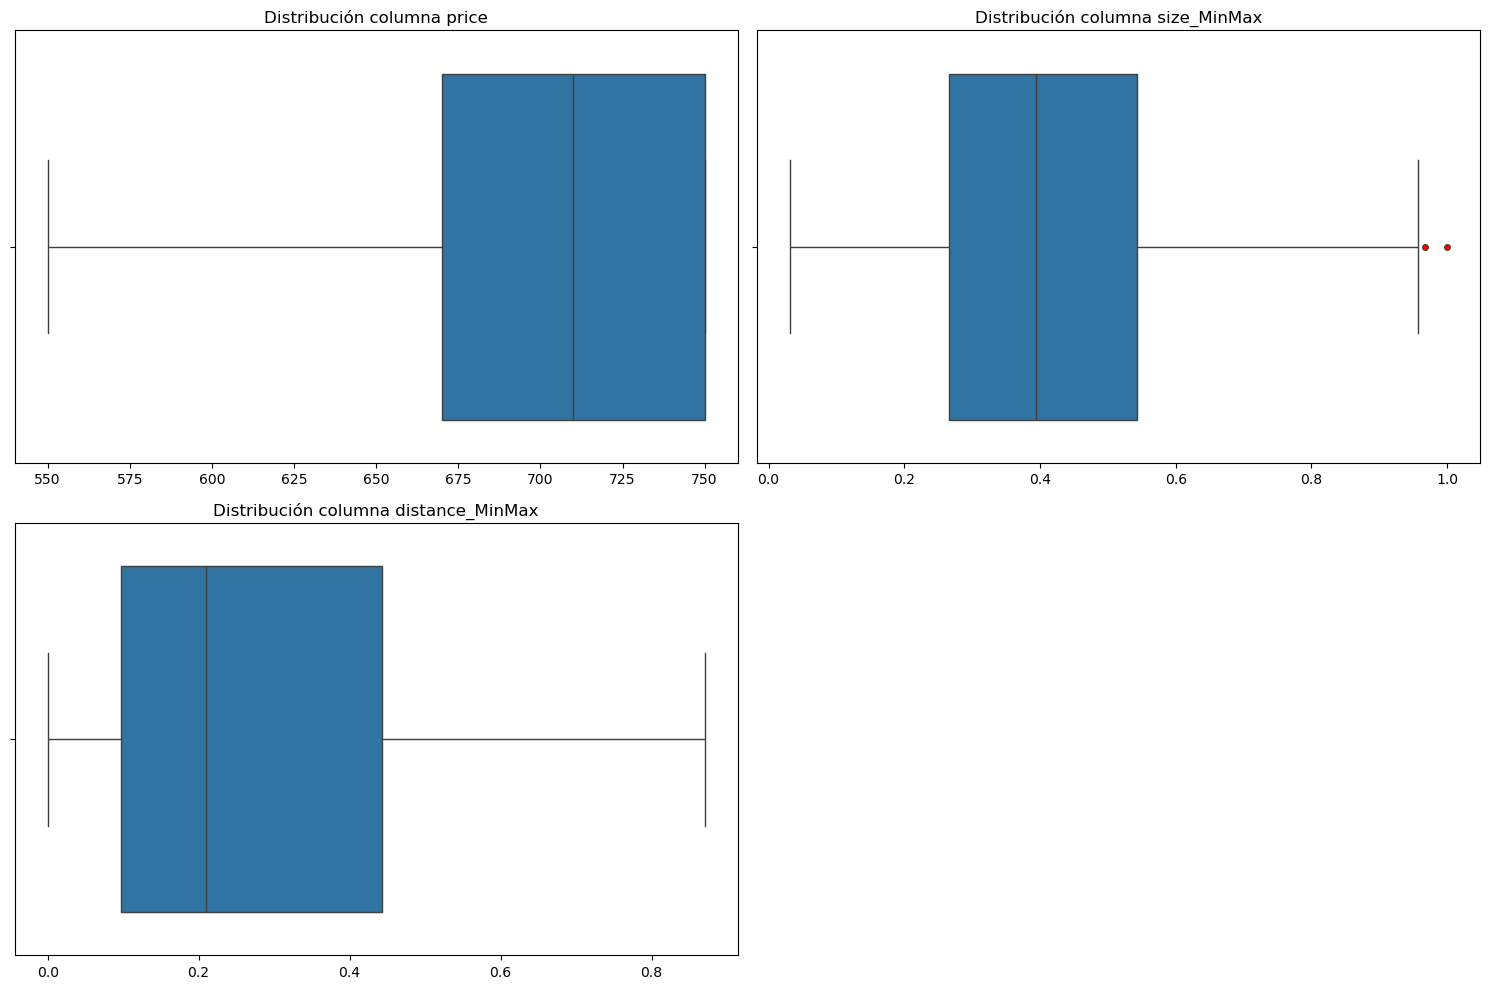

In [87]:
f.plot_outliers_univariados(df_filt_it, "b", (15,10))

In [88]:
df_est_con3=df_min[["price", "size_MinMax", "distance_MinMax"]]

In [97]:
(df_filt_it["size_MinMax"]> 0.9).sum()

7

In [96]:
(df_est_con3["size_MinMax"]> 0.9).sum()

7

In [94]:
(df_filt_it["price"]< 500).sum()

0

In [93]:
(df_est_con3["price"]< 500).sum()

0

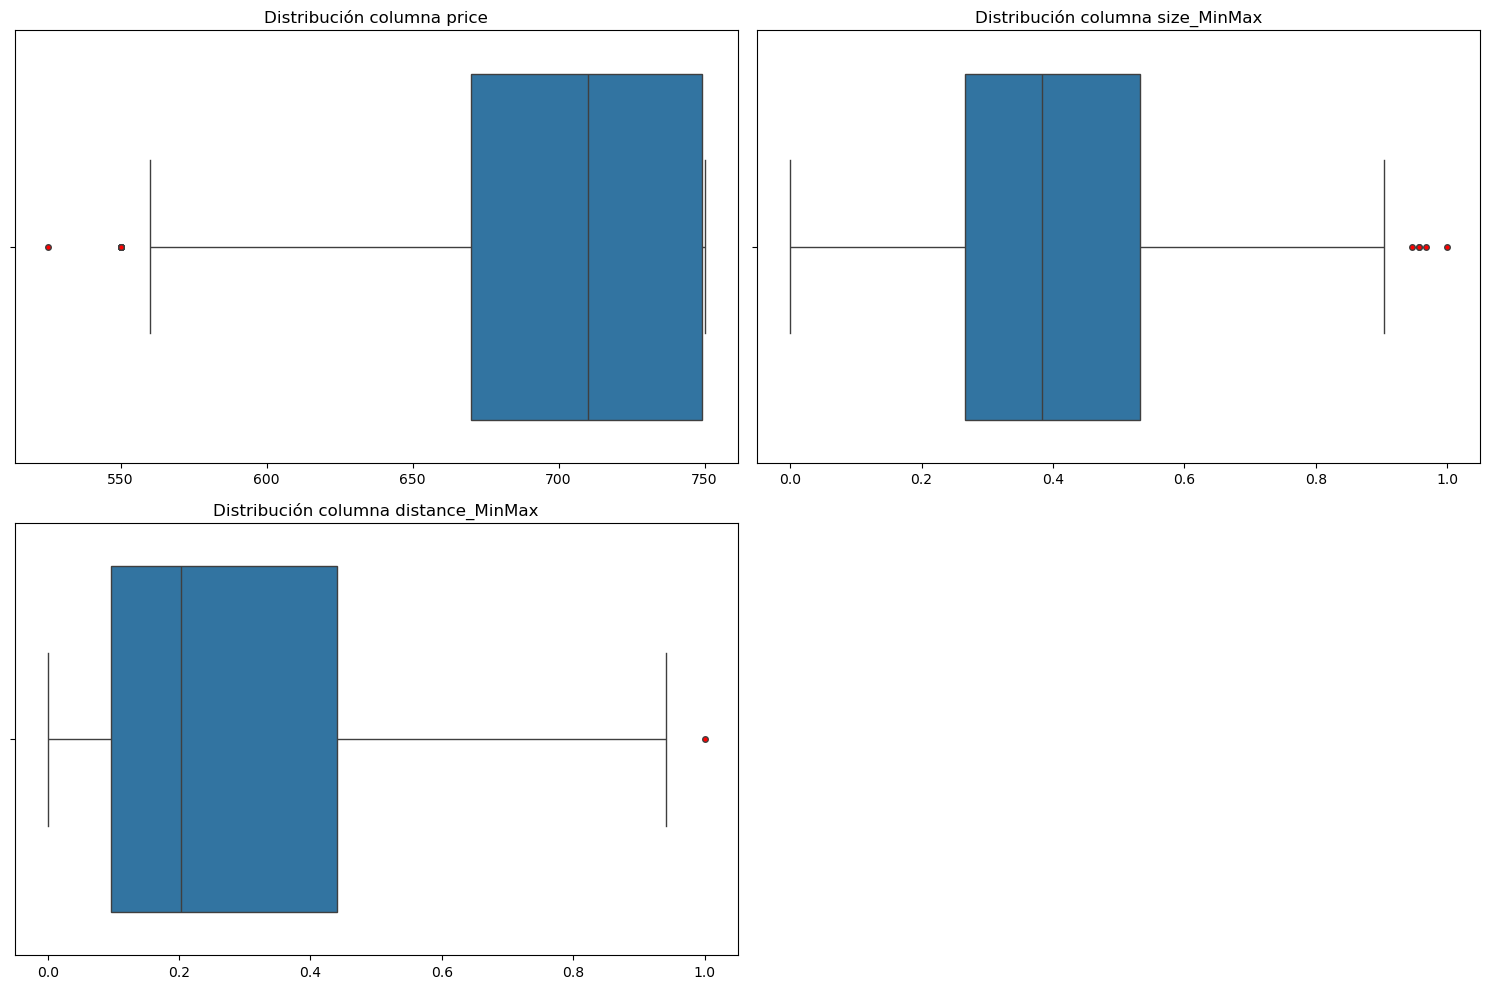

In [95]:
f.plot_outliers_univariados(df_est_con3, "b", (15,10))

Ya están tratados

Observamos que no hay diferencias muy significativas entre imputar con KNN o con ITERATIVE pero tras observar que el iterative reduce la dispersión entre la media y la mediana de size y que el KNN aumenta la desviación típica (variabilidad) en la distancia, nos decantamos finalmente por el uso del ITERATIVE